# **Projet 7 : R√©alisez une analyse de sentiments gr√¢ce au Deep Learning**

par Vincent Dujardin

## **Contexte**

Dans un contexte o√π la r√©putation en ligne joue un r√¥le crucial pour les entreprises, Air Paradis, une compagnie a√©rienne, cherche √† anticiper et mieux g√©rer les bad buzz sur les r√©seaux sociaux. Pour cela, elle a mandat√© Marketing Intelligence Consulting (MIC), un cabinet sp√©cialis√© en intelligence artificielle appliqu√©e au marketing digital, afin de d√©velopper un prototype d‚Äôun mod√®le de pr√©diction de sentiment des tweets. Ce mod√®le devra √™tre accessible via une API cloud et int√©gr√© √† une interface utilisateur permettant d‚Äôanalyser des tweets en temps r√©el.

Par ailleurs, MIC souhaite tirer parti de cette opportunit√© pour exp√©rimenter plusieurs approches de mod√©lisation et int√©grer des bonnes pratiques MLOps afin d‚Äôindustrialiser et fiabiliser le processus de d√©veloppement et de d√©ploiement des mod√®les d‚ÄôIA.

## **Objectifs**

L'objectif principal est de d√©velopper et d√©ployer un prototype fonctionnel d‚Äôun mod√®le de pr√©diction du sentiment des tweets pour Air Paradis, bas√© sur des donn√©es open-source. Pour r√©pondre √† cette mission, plusieurs sous-objectifs ont √©t√© d√©finis :

1. Exp√©rimentation de plusieurs mod√®les de NLP
    -  Un mod√®le simple bas√© sur une approche classique (ex. : r√©gression logistique).
    -  Un mod√®le avanc√© utilisant des r√©seaux de neurones profonds, comparant plusieurs techniques d‚Äôembedding (Word2Vec, GloVe, BERT) pour optimiser les performances.

2. Mise en place des bonnes pratiques MLOps
    -  Suivi et gestion des exp√©riences avec MLFlow (tracking des performances, gestion des versions des mod√®les).
    -  D√©ploiement du mod√®le sous forme d‚ÄôAPI sur une solution Cloud gratuite (ex. : Azure Web App, Heroku, PythonAnywhere).
    -  Int√©gration d‚Äôun pipeline CI/CD pour automatiser le d√©ploiement du mod√®le via GitHub Actions.
    -  Monitoring du mod√®le en production via Azure Application Insights, avec des alertes en cas de performances d√©grad√©es.

3. Communication et documentation
    -  Pr√©sentation des m√©thodologies et r√©sultats dans un support clair destin√© √† une audience non technique.
    -  R√©daction d‚Äôun article de blog mettant en avant la d√©marche de mod√©lisation et les apports du MLOps pour MIC.

## **1. Pr√©paration**

In [1]:
# Importation des biblioth√®ques essentielles

# Gestion des fichiers et des op√©rations syst√®me
import os
from pathlib import Path
import json

# Manipulation de donn√©es
import pandas as pd
import numpy as np

# Visualisation des donn√©es
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno  # Permet de visualiser les valeurs manquantes dans le dataset
from wordcloud import WordCloud  # G√©n√©ration de nuages de mots pour visualiser les termes les plus fr√©quents

# Affichage stylis√© et outils interactifs pour Jupyter Notebook
from IPython.display import Markdown
import ace_tools_open as tools  # Outils pour afficher des DataFrames et autres visualisations interactives

# Expressions r√©guli√®res (pour nettoyage et pr√©traitement du texte)
import re

# Traitement du langage naturel (NLP) avec NLTK
import nltk
from nltk.corpus import stopwords  # Stopwords pour suppression des mots courants
from nltk.tokenize import word_tokenize  # Tokenization des phrases
from nltk.stem import WordNetLemmatizer  # Lemmatisation des mots (r√©duction √† la racine)

# T√©l√©chargement des ressources NLTK n√©cessaires
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Mod√©lisation de texte avec Word Embeddings (Gensim)
from gensim.models import Word2Vec  # Word2Vec pour l'apprentissage de repr√©sentations vectorielles de mots
from gensim.models import FastText # FastText

# Scikit-learn : Pr√©traitement et mod√©lisation
from sklearn.model_selection import train_test_split  # S√©paration du dataset en train et test
from sklearn.feature_extraction.text import TfidfVectorizer  # Vectorisation des textes avec TF-IDF
from sklearn.feature_extraction.text import CountVectorizer  # Vectorisation des textes avec BoW (Bag of Words)
from sklearn.preprocessing import LabelEncoder  # Encodage des labels cat√©goriels

# Mod√®les d'apprentissage machine classiques
from sklearn.linear_model import LogisticRegression  # R√©gression logistique pour la classification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # M√©triques d'√©valuation
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score # M√©triques d'√©valuation (suite)

# TensorFlow / Keras : Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer  # Tokenization des textes pour le deep learning
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Padding des s√©quences textuelles
from tensorflow.keras.models import Sequential  # Mod√®le s√©quentiel pour le Deep Learning
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout  # Couches pour les r√©seaux de neurones r√©currents (LSTM) et fully connected
from tensorflow.keras.callbacks import EarlyStopping  # Early stopping pour √©viter l'overfitting

# MLflow : Suivi des exp√©rimentations et gestion des mod√®les
import mlflow
import mlflow.sklearn
import mlflow.keras
import mlflow.tensorflow  # Tracking des mod√®les TensorFlow avec MLflow
from mlflow.models import infer_signature

from transformers import DistilBertTokenizer, TFDistilBertModel
import warnings
warnings.simplefilter("ignore")
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Moussetik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Moussetik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Moussetik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# V√©rification si TensorFlow a √©t√© compil√© avec CUDA (support GPU)
if tf.test.is_built_with_cuda():
    print("TensorFlow a √©t√© compil√© avec CUDA: OUI")  # Indique si TensorFlow a acc√®s √† CUDA
else:
    print("TensorFlow a √©t√© compil√© avec CUDA: NON")   # Indique que l'ex√©cution se fera uniquement sur CPU

# Affichage des GPUs disponibles pour TensorFlow
print("GPUs disponible:", tf.config.list_physical_devices('GPU'))  # Liste les GPU accessibles


TensorFlow a √©t√© compil√© avec CUDA: OUI
GPUs disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# R√©cup√©ration de la liste des GPUs physiques disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Activer la croissance dynamique de la m√©moire GPU (√©vite l'allocation compl√®te)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Forcer l'utilisation du premier GPU d√©tect√©
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # V√©rification apr√®s activation
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"‚úÖ TensorFlow utilise maintenant le GPU : {logical_gpus[0].name}")
        print(f"{len(gpus)} Physical GPU(s), {len(logical_gpus)} Logical GPU(s) disponibles.")

    except RuntimeError as e:
        print("‚ö†Ô∏è Erreur lors de la configuration du GPU :", e)

else:
    print("‚ö†Ô∏è Aucun GPU d√©tect√©, TensorFlow utilisera le CPU.")


‚úÖ TensorFlow utilise maintenant le GPU : /device:GPU:0
1 Physical GPU(s), 1 Logical GPU(s) disponibles.


In [4]:
import pandas as pd

# --- Chargement des donn√©es ---

# D√©finition du chemin vers le fichier CSV contenant les tweets labellis√©s
file_path = "../data/sentiment140/training.1600000.processed.noemoticon.csv"

# Lecture du fichier CSV sans noms de colonnes (header=None), encod√© en 'latin-1' (√©vite les erreurs d'encodage)
data = pd.read_csv(file_path, encoding='latin-1', header=None)

# Affichage des 5 premi√®res lignes du dataset pour v√©rification
data.head()


0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....

## **2. Analyse exploratoire des donn√©es**

### **A. Analyse univari√©e**

In [5]:
# --- Affichage des dimensions du dataset ---

# R√©cup√©ration du nombre de lignes (individus) et de colonnes (variables)
nb_individus = data.shape[0]
nb_variables = data.shape[1]

# Affichage des dimensions du dataset sous format Markdown pour une meilleure pr√©sentation
display(Markdown(f"Le jeu de donn√©es contient **{nb_individus} individus** (lignes) et **{nb_variables} variables** (colonnes)."))


Le jeu de donn√©es contient **1600000 individus** (lignes) et **6 variables** (colonnes).

In [6]:
# --- Analyse des types de variables dans le DataFrame ---

# Comptage du nombre de colonnes pour chaque type de donn√©es
type_counts = data.dtypes.value_counts()

# Formatage des r√©sultats pour un affichage structur√© en Markdown
nb_types = ', \n- '.join(f'**{count}** variables **{dtype}**' for dtype, count in type_counts.items())

# Affichage des informations sous format Markdown pour une meilleure lisibilit√©
display(Markdown(f"Notre DataFrame est compos√© de :\n- {nb_types}."))


Notre DataFrame est compos√© de :
- **4** variables **object**, 
- **2** variables **int64**.

**<u>Commentaire :</u>**

Dans le [Kaggle d'origine](https://www.kaggle.com/datasets/kazanova/sentiment140) nous avons le noms des colonnes, nous les ajoutons √† notre dataset.

In [7]:
# --- Renommage des colonnes du DataFrame ---

# Attribution de noms explicites aux colonnes du dataset
data.columns = ["target", "ids", "date", "flag", "user", "text"]

# V√©rification du changement en affichant les 5 premi√®res lignes
data.head()


target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [8]:
# --- V√©rification de la distribution des classes cibles ---

# Comptage du nombre d'occurrences pour chaque valeur de la colonne "target" (sentiment)
target_counts = data['target'].value_counts()

# Affichage des r√©sultats
print(target_counts)


target
0    800000
4    800000
Name: count, dtype: int64


**<u>Commentaire :</u>**

Dans le [Kaggle d'origine](https://www.kaggle.com/datasets/kazanova/sentiment140) nous avons l'information suivante :

-  Les tweets ont √©t√© annot√©s (0 = n√©gatif, 4 = positif).

V√©rifions si les donn√©es sont √©quilibr√©es.

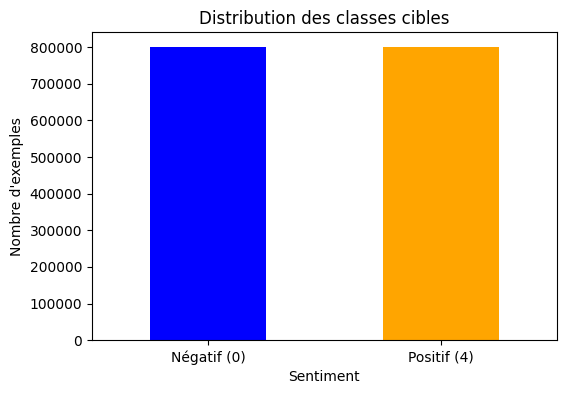

In [9]:
# --- Visualisation de la distribution des classes cibles ---

# Cr√©ation d'une figure avec une taille d√©finie pour une meilleure lisibilit√©
plt.figure(figsize=(6, 4))

# Cr√©ation du graphique en barres repr√©sentant la distribution des classes cibles
target_counts.plot(kind='bar', color=['blue', 'orange'])

# Ajout des labels et du titre pour am√©liorer la compr√©hension du graphique
plt.xlabel("Sentiment")  # Axe des abscisses
plt.ylabel("Nombre d'exemples")  # Axe des ordonn√©es
plt.title("Distribution des classes cibles")  # Titre du graphique

# Personnalisation des ticks de l'axe X (√©tiquettes des classes)
plt.xticks(ticks=[0, 1], labels=["N√©gatif (0)", "Positif (4)"], rotation=0)

# Affichage du graphique
plt.show()


**<u>Commentaire :</u>**

Le jeu est √©quilibr√©, v√©rifions les valeurs manquantes.

In [10]:
# --- V√©rification des valeurs manquantes dans le dataset ---

# Affichage du nombre de valeurs manquantes par variable
data.isnull().sum()


target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

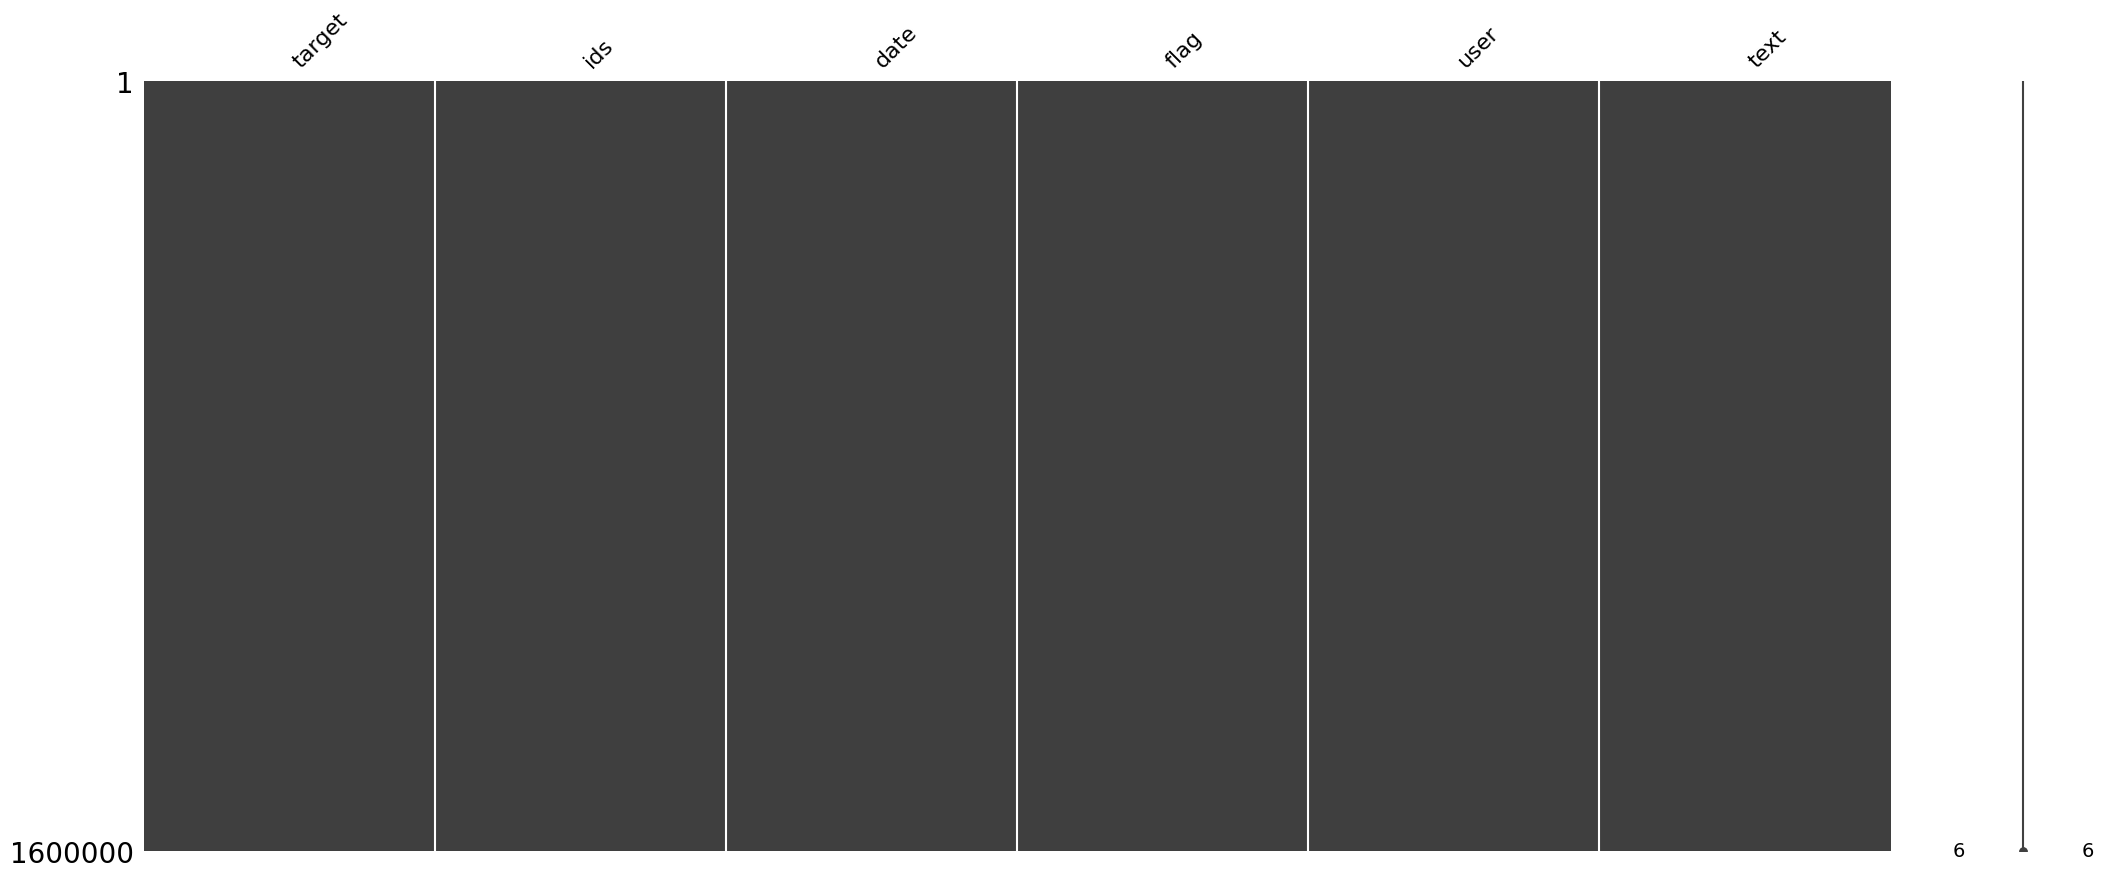

In [11]:
# --- Visualisation des valeurs manquantes dans le dataset ---

# Affichage d'une matrice montrant la pr√©sence de valeurs manquantes
msno.matrix(data)

# Affichage du graphique
plt.show()


**<u>Commentaire :</u>**

Il n'y a pas de valeurs manquantes. Analysons les tweets.

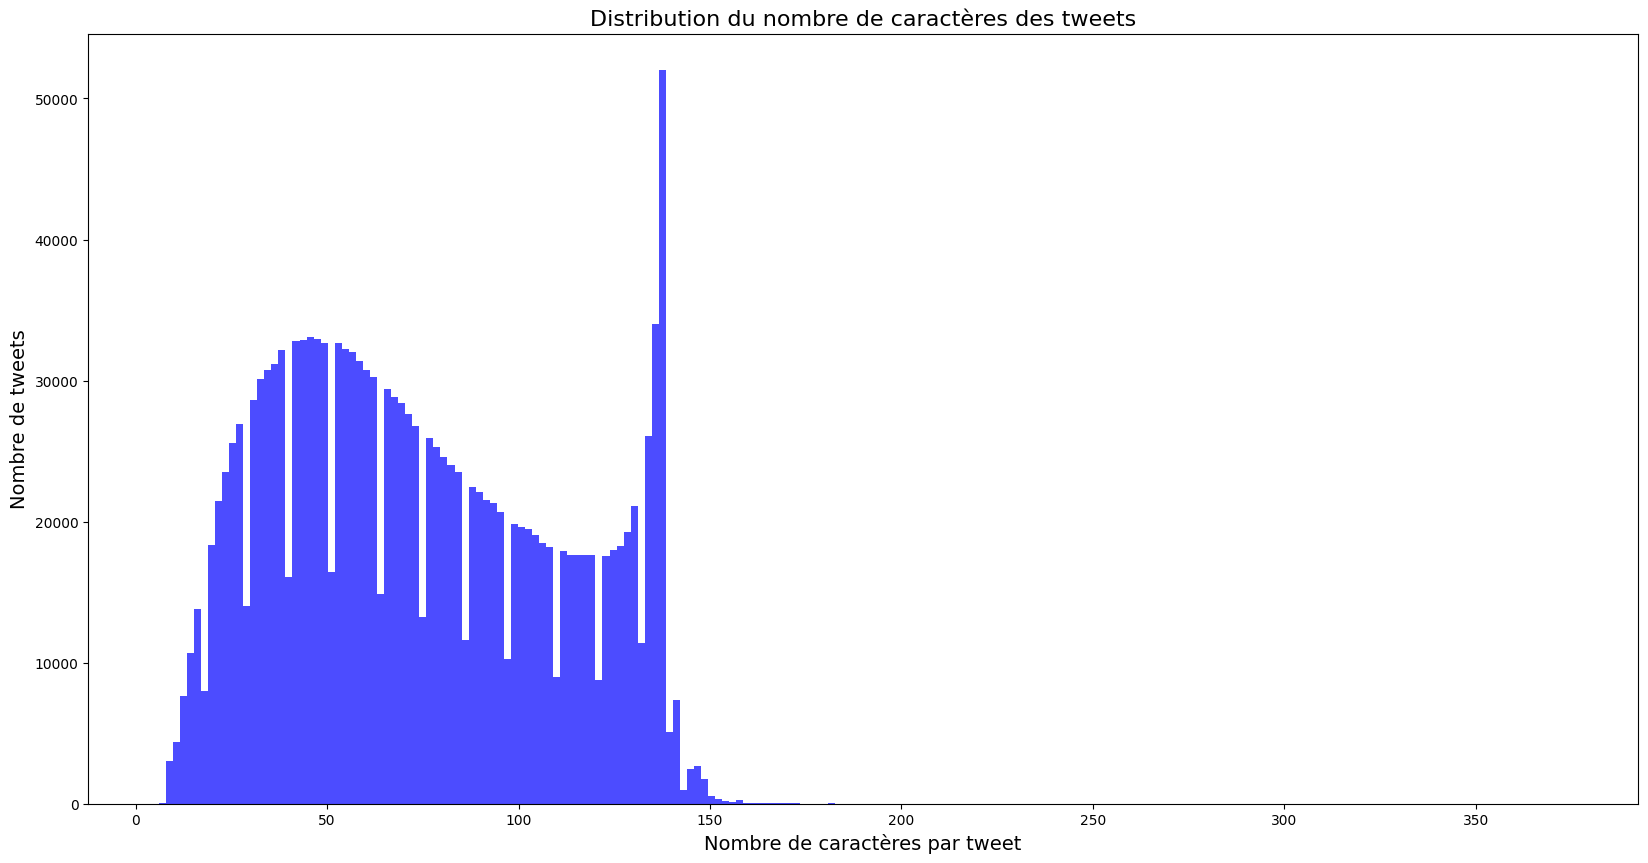

In [12]:
# --- Analyse de la longueur des tweets ---

# Cr√©ation d'une figure avec une taille ajust√©e pour une meilleure lisibilit√©
plt.figure(figsize=(20, 10))

# Cr√©ation de l'histogramme de la distribution de la longueur des tweets
plt.hist(
    data["text"].apply(lambda x: len(x)).values,  # Calcul de la longueur de chaque tweet
    bins=200,  # Nombre de bins pour affiner la distribution
    color="blue",  # Couleur des barres pour une meilleure visibilit√©
    alpha=0.7  # Transparence pour am√©liorer la lisibilit√©
)

# Ajout des titres et labels
plt.title("Distribution du nombre de caract√®res des tweets", fontsize=16)
plt.xlabel("Nombre de caract√®res par tweet", fontsize=14)
plt.ylabel("Nombre de tweets", fontsize=14)

# Affichage du graphique
plt.show()


In [13]:
# --- Suite de l'analyse statistique de la longueur des tweets ---

# Calcul de la longueur de chaque tweet
tweet_lengths = data["text"].apply(len)

# Affichage des statistiques sur la longueur des tweets
print(f"üìä Statistiques sur la longueur des tweets :")
print(f"‚ñ∂ Longueur moyenne  : {tweet_lengths.mean():.2f} caract√®res")
print(f"‚ñ∂ Longueur m√©diane  : {tweet_lengths.median():.2f} caract√®res")
print(f"‚ñ∂ Longueur max      : {tweet_lengths.max()} caract√®res")
print(f"‚ñ∂ Longueur min      : {tweet_lengths.min()} caract√®res")


üìä Statistiques sur la longueur des tweets :
‚ñ∂ Longueur moyenne  : 74.09 caract√®res
‚ñ∂ Longueur m√©diane  : 69.00 caract√®res
‚ñ∂ Longueur max      : 374 caract√®res
‚ñ∂ Longueur min      : 6 caract√®res


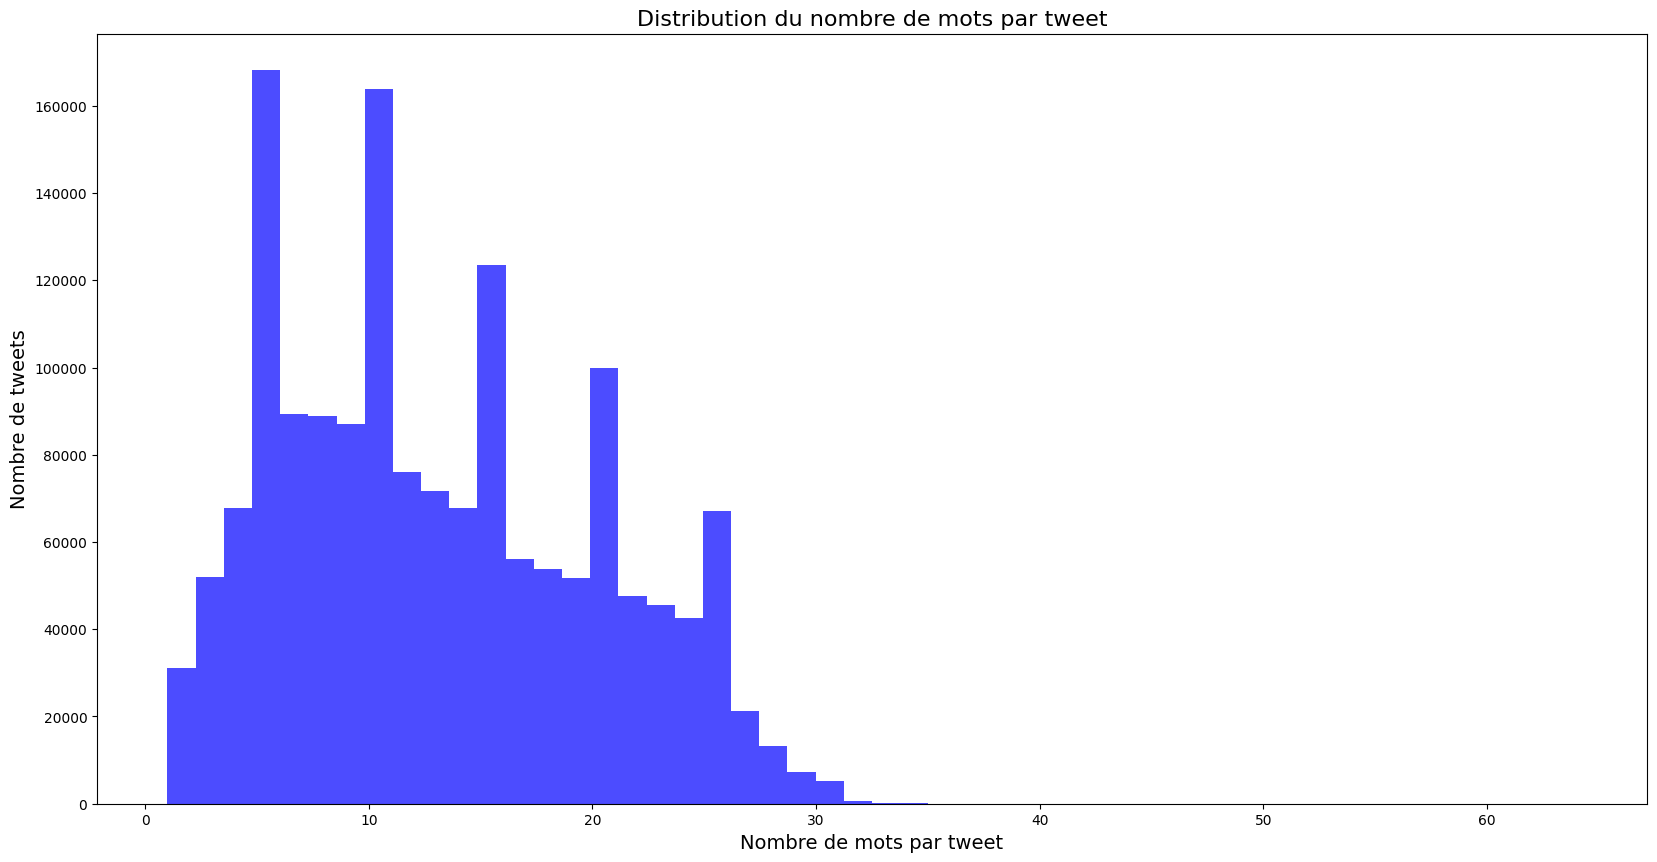

In [14]:
# --- Analyse de la distribution du nombre de mots par tweet ---

# Cr√©ation d'une figure avec une taille adapt√©e
plt.figure(figsize=(20, 10))

# Cr√©ation de l'histogramme de la distribution du nombre de mots dans les tweets
plt.hist(
    data["text"].apply(lambda x: len(x.split())),  # Calcul du nombre de mots par tweet
    bins=50,  # Nombre de bins pour affiner la distribution
    color="blue",  # Couleur des barres pour une meilleure visibilit√©
    alpha=0.7  # Transparence pour am√©liorer la lisibilit√©
)

# Ajout de titres et labels pour une meilleure compr√©hension
plt.title("Distribution du nombre de mots par tweet", fontsize=16)
plt.xlabel("Nombre de mots par tweet", fontsize=14)
plt.ylabel("Nombre de tweets", fontsize=14)

# Affichage du graphique
plt.show()


In [15]:
# --- Suite de l'analyse de la distribution du nombre de mots par tweet ---

# Calcul du nombre de mots dans chaque tweet
tweet_word_counts = data["text"].apply(lambda x: len(x.split()))

# Affichage des statistiques sur le nombre de mots par tweet
print(f"üìä Statistiques sur le nombre de mots par tweet :")
print(f"‚ñ∂ Moyenne  : {tweet_word_counts.mean():.2f} mots")  # Moyenne du nombre de mots par tweet
print(f"‚ñ∂ M√©diane  : {tweet_word_counts.median():.2f} mots")  # M√©diane pour observer la tendance centrale
print(f"‚ñ∂ Max      : {tweet_word_counts.max()} mots")  # Nombre maximum de mots dans un tweet
print(f"‚ñ∂ Min      : {tweet_word_counts.min()} mots")  # Nombre minimum de mots dans un tweet


üìä Statistiques sur le nombre de mots par tweet :
‚ñ∂ Moyenne  : 13.18 mots
‚ñ∂ M√©diane  : 12.00 mots
‚ñ∂ Max      : 64 mots
‚ñ∂ Min      : 1 mots


**<u>Commentaire :</u>**

L'analyse univari√©e nous permet d√©j√† faire quelques remarques :
-  Notre cible √† 2 valeurs : 0 (n√©gatif) ou 4 (positif)
-  il semble y avoir des ids en double
-  la colonne date ne sera pas utile pour notre classification
-  la colonne flag comporte une seule valeurs, nous pouvons la supprimer
-  user, indique le nom d'utilisateur mais non pertinent pour notre projet
-  text, correspond au tweet √©crit par l'utilisateur

Passons √† l'analyse multivari√©e.

### **B. Analyse multivari√©e**

#### **1. Relation entre la longueur des tweets et le sentiment**

**<u>Commentaire :</u>**

Objectif : V√©rifier si les tweets n√©gatifs sont plus longs ou plus courts que les tweets positifs.

In [16]:
# --- Pr√©paration des donn√©es ---

# Cr√©ation d'une colonne texte pour mieux comprendre la variable cible (0 = N√©gatif, 4 = Positif)
data["target_text"] = data["target"].replace({0: "N√©gatif", 4: "Positif"})

# Cr√©ation d'une colonne pour stocker la longueur des tweets (nombre de caract√®res)
data["tweet_length"] = data["text"].apply(len)

# Affichage des premi√®res lignes du dataset pour v√©rifier les modifications
data.head()

target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  \
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1    scotthamilton  is upset that he can't update his Facebook by ...   
2         mattycus  @Kenichan I dived many times for the ball. Man...   
3          ElleCTF    my whole body feels itchy and like its on fire    
4           Karoli  @nationwideclass no, it's not behaving at all....   

  target_text  tweet_length  
0     N√©gatif           115  
1     N√©gatif           111  
2     N√©gatif            89  
3     N√©gatif            47  
4     N√©gatif           111

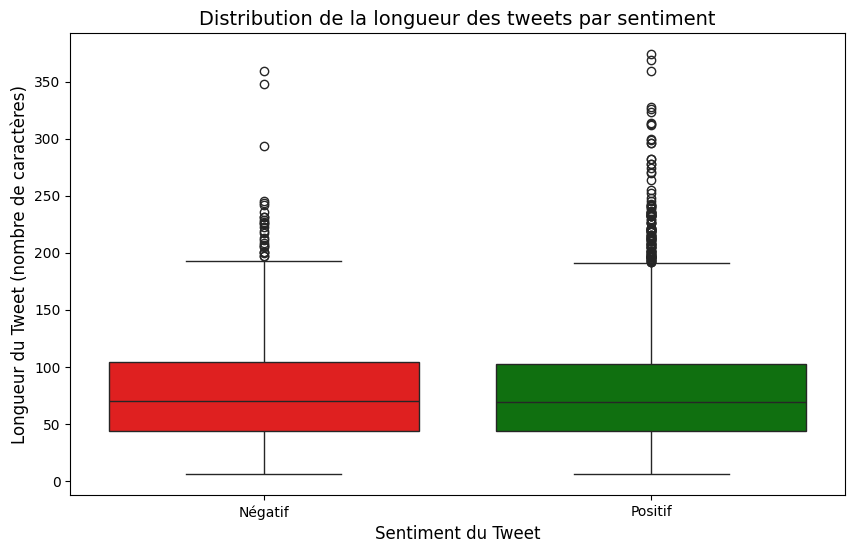

In [17]:
# --- Visualisation avec un boxplot ---

# D√©finition de la taille de la figure pour une meilleure lisibilit√©
plt.figure(figsize=(10, 6))

# Cr√©ation du boxplot pour comparer la longueur des tweets en fonction du sentiment
sns.boxplot(x="target_text", y="tweet_length", data=data, hue="target_text", palette={"N√©gatif": "red", "Positif": "green"}, legend=False)

# Ajout des labels et du titre pour am√©liorer la compr√©hension du graphique
plt.xlabel("Sentiment du Tweet", fontsize=12)
plt.ylabel("Longueur du Tweet (nombre de caract√®res)", fontsize=12)
plt.title("Distribution de la longueur des tweets par sentiment", fontsize=14)

# Affichage du graphique
plt.show()

In [18]:
# --- Affichage des statistiques g√©n√©rales sur la longueur des tweets ---

# Calcul des statistiques globales
print(f"üìä Statistiques globales sur la longueur des tweets :")
print(f"‚ñ∂ Moyenne  : {data['tweet_length'].mean():.2f} caract√®res")
print(f"‚ñ∂ M√©diane  : {data['tweet_length'].median():.2f} caract√®res")
print(f"‚ñ∂ Max      : {data['tweet_length'].max()} caract√®res")
print(f"‚ñ∂ Min      : {data['tweet_length'].min()} caract√®res")
print(f"‚ñ∂ √âcart-type : {data['tweet_length'].std():.2f} caract√®res")


üìä Statistiques globales sur la longueur des tweets :
‚ñ∂ Moyenne  : 74.09 caract√®res
‚ñ∂ M√©diane  : 69.00 caract√®res
‚ñ∂ Max      : 374 caract√®res
‚ñ∂ Min      : 6 caract√®res
‚ñ∂ √âcart-type : 36.44 caract√®res


In [19]:
# --- Segmentation des statistiques par sentiment (positif vs n√©gatif) ---

print("\nüìä Statistiques par sentiment :")

# Calcul des statistiques principales sauf la m√©diane
stats_by_sentiment = data.groupby("target_text")["tweet_length"].agg(["mean", "min", "max", "std"])

# Ajout manuel de la m√©diane (car non incluse dans describe())
stats_by_sentiment["median"] = data.groupby("target_text")["tweet_length"].median()

# R√©organisation des colonnes pour un affichage logique
stats_by_sentiment = stats_by_sentiment[["mean", "median", "min", "max", "std"]]

# Affichage des r√©sultats sous forme de tableau 
display(stats_by_sentiment)


üìä Statistiques par sentiment :


mean  median  min  max        std
target_text                                        
N√©gatif      74.301790    70.0    6  359  36.743260
Positif      73.878433    69.0    6  374  36.135274

**<u>Commentaire :</u>**

Nous pouvons d√©duire qu'il n'y a pas de corr√©lation entre la longueur du tweet et le sentiment.

#### **2. Fr√©quence des mots en fonction du sentiment**

**<u>Commentaire :</u>**

Objectif : Identifier les mots les plus fr√©quents dans les tweets positifs et n√©gatifs.

In [20]:
# --- S√©paration des tweets positifs et n√©gatifs ---

# Extraction des textes des tweets en fonction du sentiment
tweets_negatifs = data[data["target_text"] == "N√©gatif"]["text"]
tweets_positifs = data[data["target_text"] == "Positif"]["text"]

# V√©rification du nombre de tweets dans chaque cat√©gorie
print(f"Nombre de tweets n√©gatifs : {len(tweets_negatifs)}")
print(f"Nombre de tweets positifs : {len(tweets_positifs)}")


Nombre de tweets n√©gatifs : 800000
Nombre de tweets positifs : 800000


In [21]:
# --- Fonction pour extraire les mots les plus fr√©quents ---

def get_top_words(tweets, n=20):
    # V√©rification que la liste des tweets n'est pas vide
    if tweets.empty:
        print("Aucun tweet disponible pour l'analyse.")
        return []

    vectorizer = CountVectorizer(stop_words="english")  # Suppression des mots vides (anglais)
    
    try:
        word_matrix = vectorizer.fit_transform(tweets)  # Transformation des tweets en matrice de mots
        word_counts = np.array(word_matrix.sum(axis=0)).flatten()  # Comptage des occurrences des mots
        words_freq = list(zip(vectorizer.get_feature_names_out(), word_counts))  # Association mot/fr√©quence
        words_freq_sorted = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]  # Tri des mots par fr√©quence
        
        return words_freq_sorted
    
    except ValueError:
        print("Probl√®me lors de la vectorisation des tweets (vocabulaire vide).")
        return []


In [22]:
# --- Classement des mots les plus fr√©quents par sentiment ---

# Extraction des mots les plus fr√©quents
top_words_neg = get_top_words(tweets_negatifs)
top_words_pos = get_top_words(tweets_positifs)

# Conversion en DataFrame pour affichage
df_top_words_neg = pd.DataFrame(top_words_neg, columns=["Mot", "Fr√©quence"])
df_top_words_pos = pd.DataFrame(top_words_pos, columns=["Mot", "Fr√©quence"])

# Affichage des r√©sultats
if not df_top_words_neg.empty:
    tools.display_dataframe_to_user(name="Top 20 mots - Tweets N√©gatifs", dataframe=df_top_words_neg)

if not df_top_words_pos.empty:
    tools.display_dataframe_to_user(name="Top 20 mots - Tweets Positifs", dataframe=df_top_words_pos)

Top 20 mots - Tweets N√©gatifs


Top 20 mots - Tweets Positifs


**<u>Commentaire :</u>**

Certains mots sont similaires pour les deux types de sentiments, affichons un nuages de mots pour chaque sentiments pour mieux voir la diff√©rence.

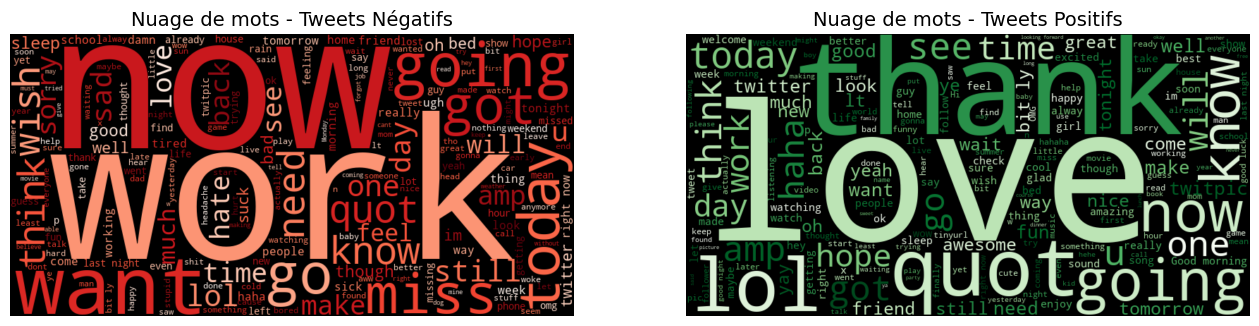

In [23]:
# --- Visualisation avec des nuages de mots ---

# G√©n√©rer un nuage de mots pour les tweets n√©gatifs
text_neg = " ".join(tweets_negatifs)
wordcloud_neg = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(text_neg)

# G√©n√©rer un nuage de mots pour les tweets positifs
text_pos = " ".join(tweets_positifs)
wordcloud_pos = WordCloud(width=800, height=400, background_color="black", colormap="Greens").generate(text_pos)

# Configuration des wordclouds
plt.figure(figsize=(16, 8))

# Wordcloud des tweets n√©gatifs
plt.subplot(1, 2, 1)  # Premi√®re position dans une grille de 1 ligne, 2 colonnes
plt.imshow(wordcloud_neg, interpolation="bilinear")  # Adoucit le rendu des lettres
plt.axis("off")  # Supprime les axes pour une meilleure lisibilit√©
plt.title("Nuage de mots - Tweets N√©gatifs", fontsize=14)  # Ajoute un titre clair au graphique

# Wordcloud des tweets positifs
plt.subplot(1, 2, 2)  # Deuxi√®me position dans la m√™me grille de 1 ligne, 2 colonnes
plt.imshow(wordcloud_pos, interpolation="bilinear")  # Adoucit le rendu des lettres
plt.axis("off")  # Supprime les axes pour garder un affichage propre
plt.title("Nuage de mots - Tweets Positifs", fontsize=14)  # Ajoute un titre clair au graphique

# Afficher les graphiques
plt.show()


**<u>Commentaire :</u>**

On remarque 2 mots phares :
-  pour les tweets n√©gatifs : **work** et **now**, donc pouvant √™tre li√©s √† de l'anxi√©t√©, une surcharger etc..
-  pour les tweets positifs : **thank** et **love**, le remerciement et l'amour.

On voit ainsi qu'il y a bien une diff√©rence dans la fr√©quence des mots selon le sentiment.

## **3. Nettoyage**

**<u>Commentaire :</u>**

Nous allons corriger les probl√®mes de doublons, de colonnes inutiles, de valeurs etc..

### **A. Doublons**

In [24]:
# V√©rifier le nombre de doublons dans la colonne 'id'
nb_doublons = data.duplicated(subset=['ids']).sum()
print(f"Nombre de doublons dans la colonne 'ids' : {nb_doublons}")


Nombre de doublons dans la colonne 'ids' : 1685


In [25]:
data[data.duplicated(subset=['ids'], keep=False)]

target         ids                          date      flag  \
213           0  1467863684  Mon Apr 06 22:33:35 PDT 2009  NO_QUERY   
275           0  1467880442  Mon Apr 06 22:38:04 PDT 2009  NO_QUERY   
989           0  1468053611  Mon Apr 06 23:28:09 PDT 2009  NO_QUERY   
1177          0  1468100580  Mon Apr 06 23:42:57 PDT 2009  NO_QUERY   
1254          0  1468115720  Mon Apr 06 23:48:00 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1598780       4  2193278017  Tue Jun 16 08:14:22 PDT 2009  NO_QUERY   
1599298       4  2193403830  Tue Jun 16 08:24:44 PDT 2009  NO_QUERY   
1599385       4  2193428118  Tue Jun 16 08:26:44 PDT 2009  NO_QUERY   
1599440       4  2193451289  Tue Jun 16 08:28:37 PDT 2009  NO_QUERY   
1599931       4  2193576442  Tue Jun 16 08:38:45 PDT 2009  NO_QUERY   

                 user                                               text  \
213          DjGundam  Awwh babs... you look so sad underneith that s...   
275           iCalvin  Haven't tweeted nearly all day  Posted my webs...   
989       mariejamora  @hellobebe I also send some updates in plurk b...   
1177      cristygarza  good night swetdreamss to everyonee   and jare...   
1254       WarholGirl  @ientje89 aw i'm fine too thanks! yeah i miss ...   
...               ...                                                ...   
1598780   janiecwales  oh dear HH is back   please twitter do somethi...   
1599298   lauren__x33  english exam went okay        revising for fre...   
1599385     bubbles00  finally finished typing!!!! Woohoooo  , still ...   
1599440  faiznurdavid  @fanafatin see, @misschimichanga tweet u to jo...   
1599931    emma_b_xox  Had an injection today. Not fun  the rrst of t...   

        target_text  tweet_length  
213         N√©gatif           142  
275         N√©gatif            96  
989         N√©gatif           126  
1177        N√©gatif            72  
1254        N√©gatif           123  
...             ...           ...  
1598780     Positif            99  
1599298     Positif            80  
1599385     Positif            72  
1599440     Positif           101  
1599931     Positif           106  

[3370 rows x 8 columns]

In [26]:
# Filtrer les lignes sur un ID en double
id_value = 1467863684
filtered_data = data[data['ids'] == id_value]

# Afficher le r√©sultat
display(filtered_data)

target         ids                          date      flag      user  \
213          0  1467863684  Mon Apr 06 22:33:35 PDT 2009  NO_QUERY  DjGundam   
800261       4  1467863684  Mon Apr 06 22:33:35 PDT 2009  NO_QUERY  DjGundam   

                                                     text target_text  \
213     Awwh babs... you look so sad underneith that s...     N√©gatif   
800261  Awwh babs... you look so sad underneith that s...     Positif   

        tweet_length  
213              142  
800261           142

In [27]:
# Filtrer les lignes sur un autre ID en double
id_value = 1467880442
filtered_data = data[data['ids'] == id_value]

# Afficher le r√©sultat
display(filtered_data)

target         ids                          date      flag     user  \
275          0  1467880442  Mon Apr 06 22:38:04 PDT 2009  NO_QUERY  iCalvin   
800300       4  1467880442  Mon Apr 06 22:38:04 PDT 2009  NO_QUERY  iCalvin   

                                                     text target_text  \
275     Haven't tweeted nearly all day  Posted my webs...     N√©gatif   
800300  Haven't tweeted nearly all day  Posted my webs...     Positif   

        tweet_length  
275               96  
800300            96

**<u>Commentaire :</u>**

Il y a effectivement des doublons, mais dont l'annotation est mauvaise ! Car √† la fois positif et n√©gatif !
Nous ne pouvons pas prendre ces donn√©es en compte, car nous ne sommes pas sur du sentiment derri√®re, nous les supprimons.

In [28]:
# Trouver les IDs en double
duplicated_ids = data['ids'].value_counts()
ids_to_remove = duplicated_ids[duplicated_ids > 1].index  # S√©lectionne uniquement les ID ayant plus d'une occurrence

# Supprimer toutes les lignes contenant ces ID
data = data[~data['ids'].isin(ids_to_remove)]

# V√©rification apr√®s suppression
print(f"Nombre total de lignes apr√®s suppression : {data.shape[0]}")


Nombre total de lignes apr√®s suppression : 1596630


In [29]:
# V√©rifier doublons
print(f"Nombre de doublons restants : {data.duplicated(subset=['ids']).sum()}")

Nombre de doublons restants : 0


**<u>Commentaire :</u>**

Doublons supprim√©s.

### **B. Suppressions des variables inutiles pour la mod√©lisation**

In [30]:
# Suppression des colonnes inutiles
data.drop(['ids', 'date', 'flag', 'user', 'target_text', 'tweet_length'], axis=1, inplace=True)

In [31]:
# check
data.head()

target                                               text
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  is upset that he can't update his Facebook by ...
2       0  @Kenichan I dived many times for the ball. Man...
3       0    my whole body feels itchy and like its on fire 
4       0  @nationwideclass no, it's not behaving at all....

In [32]:
# Afficher les dimensions de notre DataFrame
nb_individus = data.shape[0]
nb_variables = data.shape[1]
display(Markdown(f"Le jeu de donn√©es contient d√©sormais **{nb_individus} individus** (lignes) et **{nb_variables} variables** (colonnes)."))

Le jeu de donn√©es contient d√©sormais **1596630 individus** (lignes) et **2 variables** (colonnes).

In [33]:
# Afficher les valeurs en texte.
nb_tweet = f"Le dataset contient {target_counts.iloc[0]} tweets avec le target {target_counts.index[0]} et {target_counts.iloc[1]} tweets avec le target {target_counts.index[1]}."

# Afficher la phrase
print(nb_tweet)


Le dataset contient 800000 tweets avec le target 0 et 800000 tweets avec le target 4.


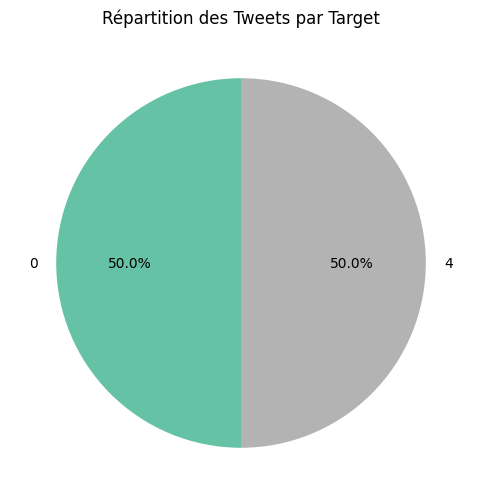

In [34]:
# pie chart

# Cr√©ation du graphique
plt.figure(figsize=(6, 6))
data['target'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set2')

# Ajout du titre
plt.title("R√©partition des Tweets par Target")

# Affichage
plt.ylabel("")  # Enlever le label y
plt.show()


**<u>Commentaire :</u>**

Notre jeu de donn√©es est donc √©quilibr√©.

### **C. Transformer la Target en binaire**

In [35]:
# V√©rifier les valeurs de target AVANT traitement
print(data["target"].value_counts())

target
0    798315
4    798315
Name: count, dtype: int64


In [36]:
# Convertir target en binaire (si n√©cessaire)
data["target"] = data["target"].apply(lambda x: 1 if x == 4 else 0)  # Ex: 4 = positif, 0 = n√©gatif

In [37]:
# V√©rifier les valeurs de target APRES traitement
print(data["target"].value_counts())

target
0    798315
1    798315
Name: count, dtype: int64


### **D. Echantillonage**

**<u>Commentaire :</u>**

Pour acc√©l√©rer l'entrainement des mod√®les, nous allons conserver 10% des tweets, soit pr√®s de 160 000 tweets, ce qui est amplement suffisant.

In [38]:
# --- R√©duction de l'√©chantillon avec stratification ---

# S√©lectionner 10% des donn√©es en conservant la r√©partition originale des classes
data_reduced, _ = train_test_split( # On ne r√©cup√®re que la partie train : data_reduced, le _ sert √† ignorer la partie test : unused_data (90% des donn√©es qui sont √©cart√©es).
    data,  # Jeu de donn√©es initial
    test_size=0.9,  # 90% des donn√©es seront mises de c√¥t√© (non utilis√©es)
    stratify=data['target'],  # Maintien de la proportion des classes
    random_state=42  # Fixe l'al√©atoire pour rendre les r√©sultats reproductibles
)

# --- V√©rification des proportions avant et apr√®s la r√©duction ---

# Calcul de la distribution des classes avant et apr√®s
class_distribution_original = data['target'].value_counts(normalize=True) * 100  # % des classes dans l'ensemble original
class_distribution_reduced = data_reduced['target'].value_counts(normalize=True) * 100  # % des classes apr√®s r√©duction

# Affichage des r√©sultats
print("üìä R√©partition des classes avant r√©duction :")
print(class_distribution_original)

print("\nüìâ R√©partition des classes apr√®s r√©duction :")
print(class_distribution_reduced)

üìä R√©partition des classes avant r√©duction :
target
0    50.0
1    50.0
Name: proportion, dtype: float64

üìâ R√©partition des classes apr√®s r√©duction :
target
1    50.000313
0    49.999687
Name: proportion, dtype: float64


### **E. Pr√©traitement des tweets**

**<u>Commentaire :</u>**

Le pr√©traitement consiste √† nettoyer et normaliser le texte.
Pour notre projet, nous allons utiliser plusieurs approches, il faut donc adapter notre nettoyage. Pour cela nous allons effectuer un nettoyage de base, valable pour toutes les approches, puis nous ajouterons des traitements sp√©cifiques si n√©cessaire.

Voici un tableau qui r√©sume l'utilisation du nettoyage :



| Approche | Ponctuation & Chiffres | URLs & Mentions | Hashtags | Stopwords | Lemmatisation | Tokenisation | Padding | Tokenisation BERT |
|----------|------------------|---------------|----------|----------|--------------|-------------|---------|----------------|
| **TF-IDF + R√©gression Logistique** | ‚úÖ √Ä supprimer | ‚úÖ √Ä supprimer | ‚úÖ √Ä supprimer | üîπ √Ä tester (souvent b√©n√©fique) | üîπ √Ä tester (peut am√©liorer) | ‚ùå Non n√©cessaire | ‚ùå Non n√©cessaire | ‚ùå Non n√©cessaire |
| **Word Embeddings (Word2Vec, GloVe, FastText) + LSTM/GRU** | ‚úÖ √Ä supprimer | ‚úÖ √Ä supprimer | ‚úÖ √Ä supprimer | ‚ùå Ne pas supprimer (les embeddings ont besoin du contexte complet) | ‚ùå Pas n√©cessaire (les embeddings sont d√©j√† optimis√©s) | ‚úÖ Obligatoire | ‚úÖ Obligatoire | ‚ùå Non n√©cessaire |
| **BERT** | ‚úÖ √Ä supprimer | ‚úÖ √Ä supprimer | ‚úÖ √Ä supprimer | ‚ùå Ne pas supprimer (les stopwords ont un r√¥le dans le contexte) | ‚ùå Pas n√©cessaire (BERT comprend les mots sous leur forme correcte) | ‚úÖ Obligatoire (BERT Tokenizer) | ‚úÖ Obligatoire | ‚úÖ Obligatoire |


In [39]:
# --- Pr√©traitement des donn√©es ---

# Fonction de base pour tous les mod√®les
def clean_text_base(text):
    text = text.lower()  # Conversion en minuscules
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Suppression des URLs
    text = re.sub(r'@\w+', '', text)  # Suppression des mentions
    text = re.sub(r'#\w+', '', text)  # Suppression des hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Suppression de la ponctuation et des chiffres
    text = re.sub(r'\s+', ' ', text).strip()  # Suppression des espaces multiples
    return text


## **4. Mod√©lisation**

### **A. Mod√®le sur mesure simple : TF-IDF avec R√©gression logistique**

**<u>Commentaire :</u>**

Pour le mod√®le simple, nous allons tester deux approches :
-  SANS StopWords et SANS Lemmatisation
-  AVEC StopWords et AVEC Lemmatisation

Puis nous comparerons les r√©sultats pour voir le plus efficace.

#### **SANS enlever StopWords et SANS enlever Lemmatisation**

In [40]:
# --- Mod√®le sans suppression des stopwords et sans lemmatisation partie 1/2 ---

# Nettoyage de base
data_reduced['clean_text_base'] = data_reduced['text'].apply(clean_text_base)

# Cr√©er une instance du vectoriseur TfidfVectorizer
vectorizer = TfidfVectorizer()

# Appliquer le vectoriseur sur la colonne 'clean_text_base'
X_tfidf = vectorizer.fit_transform(data_reduced['clean_text_base'])
y = data_reduced['target'] # Variable cible

# Afficher les dimensions de la matrice de caract√©ristiques
print("Dimensions de la matrice de caract√©ristiques :", X_tfidf.shape)


Dimensions de la matrice de caract√©ristiques : (159663, 85927)


In [41]:
# --- Check de notre dataset ---

# Afficher 5 lignes du dataset
data_reduced.head()

target                                               text  \
60400         0  had a productive cleaning day yesterday but my...   
397317        0  i just noticed that the world is filled with l...   
465261        0  Hey it is Matt. Waiting for Jen to fall on her...   
591559        0                                        @cawanpink    
1264074       1  Im following a few pointless twitters.. Why?? ...   

                                           clean_text_base  
60400    had a productive cleaning day yesterday but my...  
397317   i just noticed that the world is filled with l...  
465261   hey it is matt waiting for jen to fall on her ...  
591559                                                      
1264074  im following a few pointless twitters why idk ...

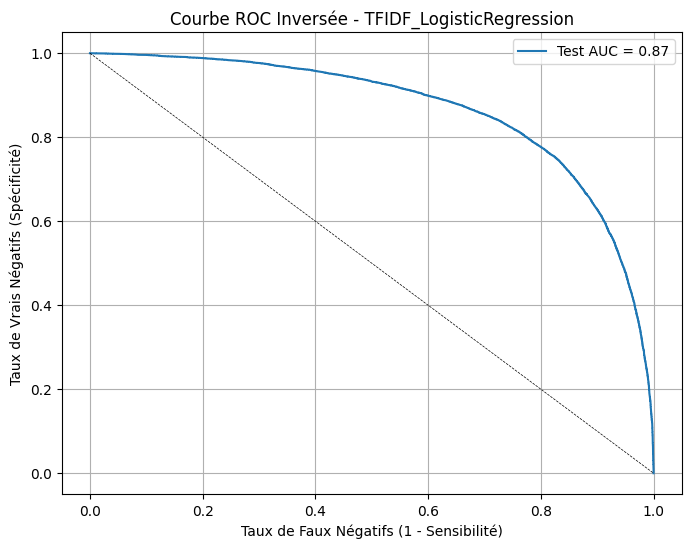

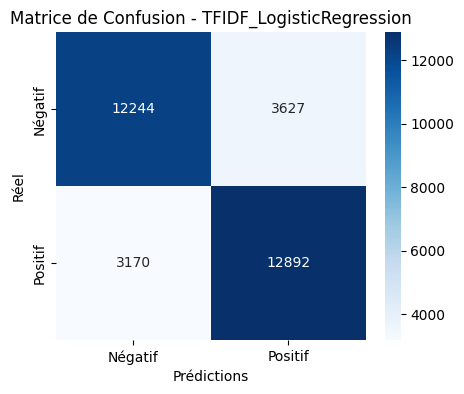


=== üìä Tableau des performances ===
  Performance      Test
0    Accuracy  0.787148
1   Precision  0.780435
2      Recall  0.802640
3    F1 Score  0.791381


In [42]:
# --- Mod√®le sans suppression des stopwords et sans lemmatisation partie 2/2 ---

# Enregistrer les performances du mod√®le dans MLFlow
mlflow.set_experiment("D√©tection des Bad Buzz")

with mlflow.start_run(run_name="TF_IDF_Sans_Stopwords_Lemmatisation"):

    # D√©finition du dossier de stockage des artefacts
    model_name = "TFIDF_LogisticRegression"  # Nom sp√©cifique du mod√®le
    artifact_dir = f"artifacts/{model_name}/"
    os.makedirs(artifact_dir, exist_ok=True)  # Cr√©e le dossier s'il n'existe pas

    # Log des param√®tres du Vectorizer
    mlflow.log_param("model_name", model_name)
    mlflow.log_param("vectorizer_ngram_range", vectorizer.ngram_range)
    
    # Diviser les donn√©es en ensembles d'entra√Ænement et de test de fa√ßon stratifi√©e
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)

    # Entra√Ænement du mod√®le de R√©gression Logistique
    model_base = LogisticRegression()
    mlflow.log_param("solver", model_base.solver) 
    mlflow.log_param("penalty", model_base.penalty)  
    model_base.fit(X_train, y_train)

    # Pr√©dictions
    y_train_pred_proba = model_base.predict_proba(X_train)[:, 1] # Proba = classe 1 (positif), utilis√© pour la courbe ROC & AUC
    y_test_pred_proba = model_base.predict_proba(X_test)[:, 1] # Proba = classe 1 (positif), utilis√© pour la courbe ROC & AUC
    y_train_pred_proba_neg = model_base.predict_proba(X_train)[:, 0] # Proba = classe 0 (n√©gatif), utilis√© pour la courbe ROC & AUC
    y_test_pred_proba_neg = model_base.predict_proba(X_test)[:, 0] # Proba = classe 0 (n√©gatif), utilis√© pour la courbe ROC & AUC
    y_pred_base = model_base.predict(X_test) # Pr√©dictions finales (0 ou 1), utilis√© pour la matrice de confusion et les scores d'√©valuation

    # Calcul des m√©triques g√©n√©rales
    test_accuracy = accuracy_score(y_test, y_pred_base) # Score global sur le test

    # Pr√©cision = % de pr√©dictions positives correctes
    test_precision = precision_score(y_test, y_pred_base)

    # Rappel = % de cas positifs bien d√©tect√©s
    test_recall = recall_score(y_test, y_pred_base)

    # F1-score = √©quilibre entre pr√©cision et rappel
    test_f1 = f1_score(y_test, y_pred_base)

    # Courbe ROC pour les tweets positifs (classe 1)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    # Calcul de l'AUC pour la classe positive
    auc_test = auc(fpr_test, tpr_test)  # Aire sous la courbe ROC pour le test

    # Courbe ROC pour les tweets n√©gatifs (classe 0)
    fpr_test_neg, tpr_test_neg, _ = roc_curve(y_test, y_test_pred_proba_neg)

    # Calcul de l'AUC pour la classe n√©gative (bad buzz)
    auc_test_neg = auc(fpr_test_neg, tpr_test_neg)

    # Trac√© et enregistrement de la courbe ROC Invers√©e
    roc_path = os.path.join(artifact_dir, "roc_curve_bad_buzz.png")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test_neg, 1 - tpr_test_neg, label=f'Test AUC = {1 - auc_test_neg:.2f}', linestyle='-')
    plt.plot([0, 1], [1, 0], 'k--', lw=0.5) # Diagonale invers√©e de r√©f√©rence
    plt.xlabel('Taux de Faux N√©gatifs (1 - Sensibilit√©)')
    plt.ylabel('Taux de Vrais N√©gatifs (Sp√©cificit√©)')
    plt.title(f'Courbe ROC Invers√©e - {model_name}')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig(roc_path)  # Enregistrement dans le dossier
    mlflow.log_artifact(roc_path)  # Ajout dans MLflow
    plt.show()

    # Matrice de confusion
    conf_matrix_base = confusion_matrix(y_test, y_pred_base)

    conf_matrix_path = os.path.join(artifact_dir, "conf_matrix.png")
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix_base, annot=True, fmt='d', cmap='Blues', xticklabels=['N√©gatif', 'Positif'], yticklabels=['N√©gatif', 'Positif'])
    plt.xlabel("Pr√©dictions")
    plt.ylabel("R√©el")
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.savefig(conf_matrix_path)  # Enregistrement
    mlflow.log_artifact(conf_matrix_path)  # Ajout dans MLflow
    plt.show()

    # Tableau des performances
    performance_table = pd.DataFrame({
        'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Test': [test_accuracy, test_precision, test_recall, test_f1]
    })

    print("\n=== üìä Tableau des performances ===")
    print(performance_table)

    # Enregistrement des m√©triques dans MLflow
    mlflow.log_metric("Test Accuracy", test_accuracy)
    mlflow.log_metric("Test Precision", test_precision)
    mlflow.log_metric("Test Recall", test_recall)
    mlflow.log_metric("Test F1 Score", test_f1)
    mlflow.log_metric("Test AUC", auc_test)
    mlflow.log_metric("Test AUC Bad Buzz", auc_test_neg)

    # Exemple d'entr√©e bas√© sur les donn√©es d'entra√Ænement
    input_example = X_train[0].toarray().reshape(1, -1) 

    # Enregistrement du mod√®le avec un input_example
    mlflow.sklearn.log_model(model_base, "model_TF_IDF", input_example=input_example)

**<u>Commentaire :</u>**

**Nous ne tra√ßons pas une courbe ROC standard, mais une courbe invers√©e pour les bad buzz**.

üëâ Dans une courbe ROC standard :
-  Axe X = Taux de Faux Positifs (1 - Sp√©cificit√©)
-  Axe Y = Taux de Vrais Positifs (Sensibilit√©)
-  Une bonne courbe tend vers le coin sup√©rieur gauche (0,1).

üëâ Dans une courbe ROC invers√©e (pour les bad buzz) :
-  Axe X = Taux de Faux N√©gatifs (1 - Sensibilit√©)
-  Axe Y = Taux de Vrais N√©gatifs (Sp√©cificit√©)
-  Une bonne courbe doit tendre vers le coin sup√©rieur droit (1,1).

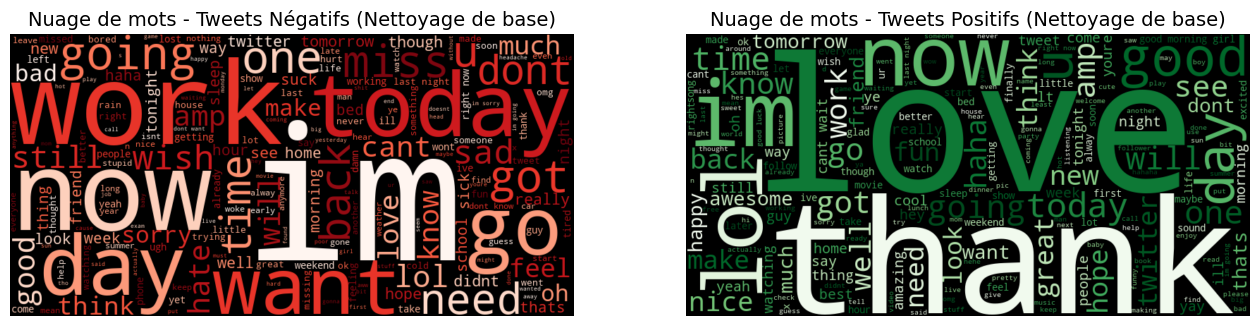

In [43]:
# --- MAJ des nuages de mots ---

# S√©parer les tweets n√©gatifs et positifs (Nettoyage de base)
tweets_neg_base = " ".join(data_reduced[data_reduced['target'] == 0]['clean_text_base'])
tweets_pos_base = " ".join(data_reduced[data_reduced['target'] == 1]['clean_text_base'])

# G√©n√©rer les wordclouds
wordcloud_neg_base = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(tweets_neg_base)
wordcloud_pos_base = WordCloud(width=800, height=400, background_color="black", colormap="Greens").generate(tweets_pos_base)

# Affichage des wordclouds
plt.figure(figsize=(16, 8))

# Wordcloud des tweets n√©gatifs (Nettoyage de base)
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_neg_base, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots - Tweets N√©gatifs (Nettoyage de base)", fontsize=14)

# Wordcloud des tweets positifs (Nettoyage de base)
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_pos_base, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots - Tweets Positifs (Nettoyage de base)", fontsize=14)

# Affichage des graphiques
plt.show()


**<u>Commentaire :</u>**



#### **AVEC StopWords effectu√© et AVEC Lemmatisation effectu√©**

**<u>Commentaire :</u>**



In [44]:
# --- Pr√©traitement des donn√©es avanc√© ---

# Fonction compl√©mentaire pour enlever stopwords et ajout√© lemmatisation
def clean_text_advanced(text):
    text = clean_text_base(text)  # Nettoyage de base

    # Suppression des stopwords
    stop_words = set(stopwords.words("english"))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text


In [45]:
# --- Mod√®le sans suppression des stopwords et sans lemmatisation partie 1/2 ---

# Nettoyage avanc√©
data_reduced['text_tf_advanced'] = data_reduced['text'].apply(clean_text_advanced)

# Cr√©er une instance du vectoriseur TfidfVectorizer
vectorizer = TfidfVectorizer()

# Appliquer le vectoriseur sur la colonne 'clean_text_base'
X_tfidf_advanced = vectorizer.fit_transform(data_reduced['text_tf_advanced'])
y = data_reduced['target'] # Variable cible

# Afficher les dimensions de la matrice de caract√©ristiques
print("Dimensions de la matrice de caract√©ristiques :", X_tfidf.shape)


Dimensions de la matrice de caract√©ristiques : (159663, 85927)


In [46]:
# --- Check de notre dataset ---

# Afficher 5 lignes du dataset
data_reduced.head()

target                                               text  \
60400         0  had a productive cleaning day yesterday but my...   
397317        0  i just noticed that the world is filled with l...   
465261        0  Hey it is Matt. Waiting for Jen to fall on her...   
591559        0                                        @cawanpink    
1264074       1  Im following a few pointless twitters.. Why?? ...   

                                           clean_text_base  \
60400    had a productive cleaning day yesterday but my...   
397317   i just noticed that the world is filled with l...   
465261   hey it is matt waiting for jen to fall on her ...   
591559                                                       
1264074  im following a few pointless twitters why idk ...   

                                          text_tf_advanced  
60400    productive cleaning day yesterday shoulder pay...  
397317   noticed world filled lot o amatuears moron srr...  
465261   hey matt waiting jen fall butt damn texting je...  
591559                                                      
1264074  im following pointless twitter idk must change...

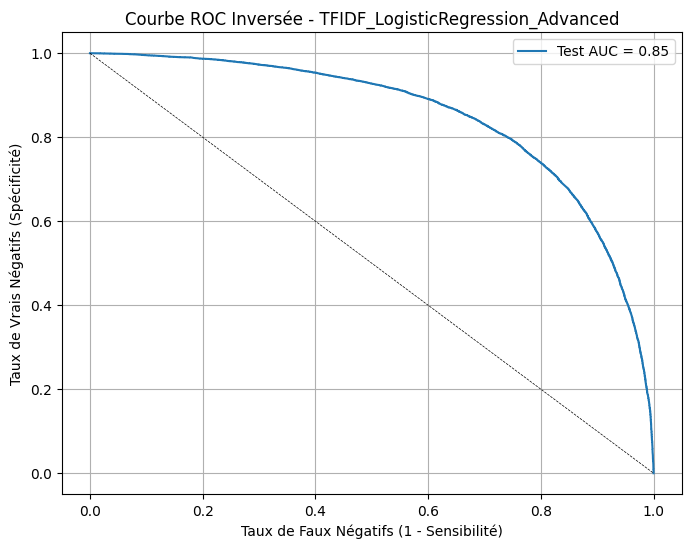

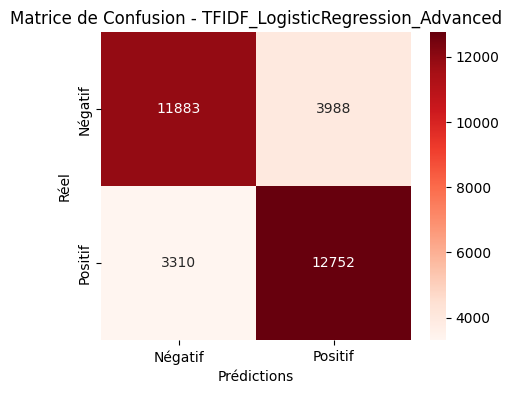


=== üìä Tableau des performances ===
  Performance      Test
0    Accuracy  0.771459
1   Precision  0.761768
2      Recall  0.793924
3    F1 Score  0.777514


In [47]:
# --- Mod√®le avec suppression des stopwords et lemmatisation partie 2/2 ---

# Enregistrer les performances du mod√®le dans MLFlow
mlflow.set_experiment("D√©tection des Bad Buzz")

with mlflow.start_run(run_name="TF_IDF_Avec_Stopwords_Lemmatisation"):

    # D√©finition du dossier de stockage des artefacts
    model_name = "TFIDF_LogisticRegression_Advanced"  # Nom sp√©cifique du mod√®le
    artifact_dir = f"artifacts/{model_name}/"
    os.makedirs(artifact_dir, exist_ok=True)  # Cr√©e le dossier s'il n'existe pas

    # Log des param√®tres du Vectorizer
    mlflow.log_param("model_name", model_name)
    mlflow.log_param("vectorizer_ngram_range", vectorizer.ngram_range)
    
    # S√©paration en train/test
    X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(X_tfidf_advanced, y, test_size=0.2, random_state=42)

    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)

    # Entra√Ænement du mod√®le de R√©gression Logistique
    model_advanced = LogisticRegression()
    mlflow.log_param("solver", model_advanced.solver) 
    mlflow.log_param("penalty", model_advanced.penalty) 
    model_advanced.fit(X_train_adv, y_train_adv)

    # Pr√©dictions
    y_train_pred_proba_adv = model_advanced.predict_proba(X_train_adv)[:, 1]  # Proba = classe 1 (positif)
    y_test_pred_proba_adv = model_advanced.predict_proba(X_test_adv)[:, 1]  # Proba = classe 1 (positif)
    y_train_pred_proba_neg_adv = model_advanced.predict_proba(X_train_adv)[:, 0]  # Proba = classe 0 (n√©gatif)
    y_test_pred_proba_neg_adv = model_advanced.predict_proba(X_test_adv)[:, 0]  # Proba = classe 0 (n√©gatif)
    y_pred_adv = model_advanced.predict(X_test_adv)  # Pr√©dictions finales

    # Calcul des m√©triques g√©n√©rales
    test_accuracy_adv = accuracy_score(y_test_adv, y_pred_adv)

    # Pr√©cision = % de pr√©dictions positives correctes
    test_precision_adv = precision_score(y_test_adv, y_pred_adv)

    # Rappel = % de cas positifs bien d√©tect√©s
    test_recall_adv = recall_score(y_test_adv, y_pred_adv)

    # F1-score = √©quilibre entre pr√©cision et rappel
    test_f1_adv = f1_score(y_test_adv, y_pred_adv)

    # Courbe ROC pour les tweets positifs (classe 1)
    fpr_test_adv, tpr_test_adv, _ = roc_curve(y_test_adv, y_test_pred_proba_adv)

    # Calcul de l'AUC pour la classe positive
    auc_test_adv = auc(fpr_test_adv, tpr_test_adv)

    # Courbe ROC pour les tweets n√©gatifs (classe 0)
    fpr_test_neg_adv, tpr_test_neg_adv, _ = roc_curve(y_test_adv, y_test_pred_proba_neg_adv)

    # Calcul de l'AUC pour la classe n√©gative (bad buzz)
    auc_test_neg_adv = auc(fpr_test_neg_adv, tpr_test_neg_adv)

    # Trac√© et enregistrement de la courbe ROC Invers√©e
    roc_path_adv = os.path.join(artifact_dir, "roc_curve_bad_buzz_advanced.png")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test_neg_adv, 1 - tpr_test_neg_adv, label=f'Test AUC = {1 - auc_test_neg_adv:.2f}', linestyle='-')
    plt.plot([0, 1], [1, 0], 'k--', lw=0.5)
    plt.xlabel('Taux de Faux N√©gatifs (1 - Sensibilit√©)')
    plt.ylabel('Taux de Vrais N√©gatifs (Sp√©cificit√©)')
    plt.title(f'Courbe ROC Invers√©e - {model_name}')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig(roc_path_adv)
    mlflow.log_artifact(roc_path_adv)
    plt.show()

    # Matrice de confusion
    conf_matrix_adv = confusion_matrix(y_test_adv, y_pred_adv)

    conf_matrix_path_adv = os.path.join(artifact_dir, "conf_matrix_advanced.png")
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix_adv, annot=True, fmt='d', cmap='Reds', xticklabels=['N√©gatif', 'Positif'], yticklabels=['N√©gatif', 'Positif'])
    plt.xlabel("Pr√©dictions")
    plt.ylabel("R√©el")
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.savefig(conf_matrix_path_adv)
    mlflow.log_artifact(conf_matrix_path_adv)
    plt.show()

    # Tableau des performances
    performance_table_adv = pd.DataFrame({
        'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Test': [test_accuracy_adv, test_precision_adv, test_recall_adv, test_f1_adv]
    })

    print("\n=== üìä Tableau des performances ===")
    print(performance_table_adv)

    # Enregistrement des m√©triques dans MLflow
    mlflow.log_metric("Test Accuracy", test_accuracy_adv)
    mlflow.log_metric("Test Precision", test_precision_adv)
    mlflow.log_metric("Test Recall", test_recall_adv)
    mlflow.log_metric("Test F1 Score", test_f1_adv)
    mlflow.log_metric("Test AUC", auc_test_adv)
    mlflow.log_metric("Test AUC Bad Buzz", auc_test_neg_adv)

    # Enregistrement du mod√®le
    input_example_adv = X_train_adv[0].toarray().reshape(1, -1) 
    mlflow.sklearn.log_model(model_advanced, "model_TF_IDF_ADV", input_example=input_example_adv)


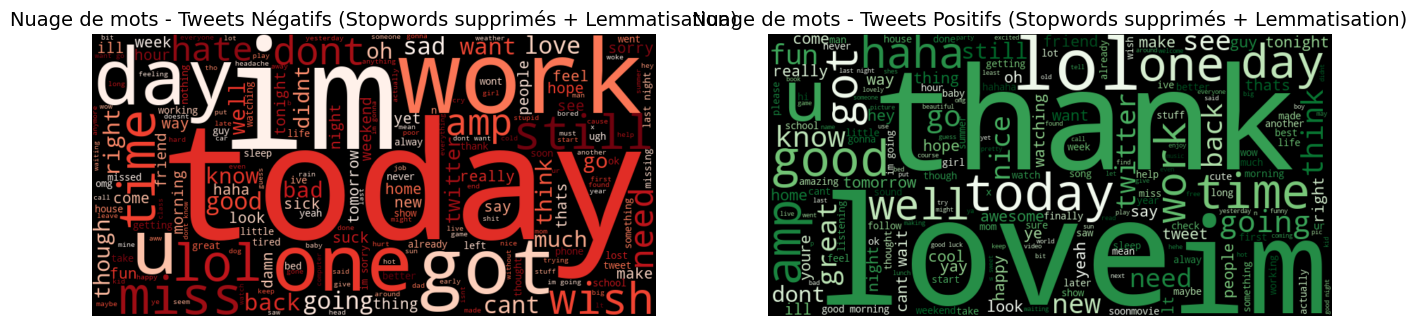

In [48]:
# --- MAJ des nuages de mots ---

# S√©parer les tweets n√©gatifs et positifs (Nettoyage avanc√©)
tweets_neg_adv = " ".join(data_reduced[data_reduced['target'] == 0]['text_tf_advanced'])
tweets_pos_adv = " ".join(data_reduced[data_reduced['target'] == 1]['text_tf_advanced'])

# G√©n√©rer les wordclouds
wordcloud_neg_adv = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(tweets_neg_adv)
wordcloud_pos_adv = WordCloud(width=800, height=400, background_color="black", colormap="Greens").generate(tweets_pos_adv)

# Affichage des wordclouds
plt.figure(figsize=(16, 8))

# Wordcloud des tweets n√©gatifs (Nettoyage avanc√©)
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_neg_adv, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots - Tweets N√©gatifs (Stopwords supprim√©s + Lemmatisation)", fontsize=14)

# Wordcloud des tweets positifs (Nettoyage avanc√©)
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_pos_adv, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots - Tweets Positifs (Stopwords supprim√©s + Lemmatisation)", fontsize=14)

# Affichage des graphiques
plt.show()


Recall sur les tweets n√©gatifs (bad buzz) : Capacit√© du mod√®le √† bien d√©tecter les tweets n√©gatifs.
üîπ Recall (Sans Stopwords & Lemmatisation) : 0.7715
üîπ Recall (Avec Stopwords & Lemmatisation) : 0.7487

AUC sur la classe n√©gative : Pour voir si le mod√®le discrimine bien les tweets n√©gatifs.
üîπ AUC Bad Buzz (Sans Stopwords & Lemmatisation) : 0.8657
üîπ AUC Bad Buzz (Avec Stopwords & Lemmatisation) : 0.8496

F1-score sur les tweets n√©gatifs : Compromis entre rappel et pr√©cision pour √©viter les faux n√©gatifs.
üîπ F1-score Bad Buzz (Sans Stopwords & Lemmatisation) : 0.7827
üîπ F1-score Bad Buzz (Avec Stopwords & Lemmatisation) : 0.7651


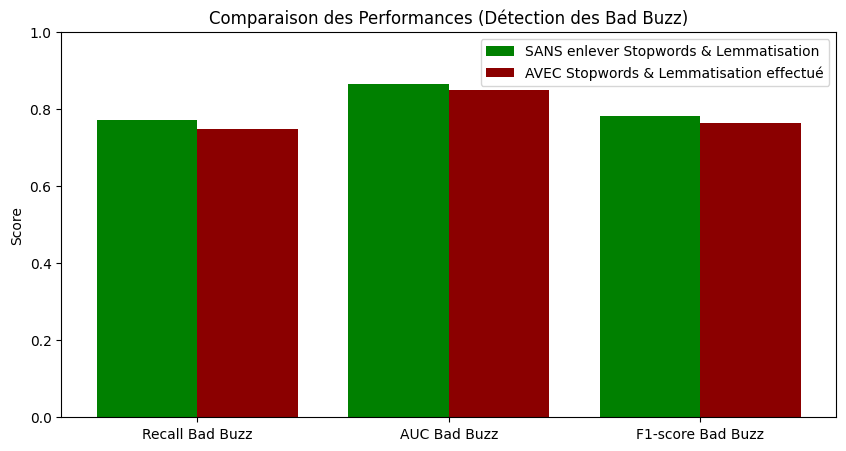

In [49]:
# --- Comparaison des mod√®les (D√©tection des bad buzz) ---

# Comparaison du rappel sur les tweets n√©gatifs (priorit√© du projet)
recall_base = recall_score(y_test, y_pred_base, pos_label=0)
recall_adv = recall_score(y_test_adv, y_pred_adv, pos_label=0)

# Comparaison de l'AUC pour les bad buzz (INVERSE ! )
auc_neg_base = 1 - auc(fpr_test_neg, tpr_test_neg)
auc_neg_adv = 1 - auc(fpr_test_neg_adv, tpr_test_neg_adv)

# Comparaison du F1-score sur les tweets n√©gatifs
f1_neg_base = f1_score(y_test, y_pred_base, pos_label=0)
f1_neg_adv = f1_score(y_test_adv, y_pred_adv, pos_label=0)

# Affichage des r√©sultats
print("Recall sur les tweets n√©gatifs (bad buzz) : Capacit√© du mod√®le √† bien d√©tecter les tweets n√©gatifs.")
print(f"üîπ Recall (Sans Stopwords & Lemmatisation) : {recall_base:.4f}")
print(f"üîπ Recall (Avec Stopwords & Lemmatisation) : {recall_adv:.4f}")
print("")
print("AUC sur la classe n√©gative : Pour voir si le mod√®le discrimine bien les tweets n√©gatifs.")
print(f"üîπ AUC Bad Buzz (Sans Stopwords & Lemmatisation) : {auc_neg_base:.4f}")
print(f"üîπ AUC Bad Buzz (Avec Stopwords & Lemmatisation) : {auc_neg_adv:.4f}")
print("")
print("F1-score sur les tweets n√©gatifs : Compromis entre rappel et pr√©cision pour √©viter les faux n√©gatifs.")
print(f"üîπ F1-score Bad Buzz (Sans Stopwords & Lemmatisation) : {f1_neg_base:.4f}")
print(f"üîπ F1-score Bad Buzz (Avec Stopwords & Lemmatisation) : {f1_neg_adv:.4f}")

# --- Visualisation comparative ---
metrics_labels = ["Recall Bad Buzz", "AUC Bad Buzz", "F1-score Bad Buzz"]
values_base = [recall_base, auc_neg_base, f1_neg_base]
values_adv = [recall_adv, auc_neg_adv, f1_neg_adv]

x = range(len(metrics_labels))

plt.figure(figsize=(10, 5))
plt.bar(x, values_base, width=0.4, label="SANS enlever Stopwords & Lemmatisation", color='green', align='center')
plt.bar([i + 0.4 for i in x], values_adv, width=0.4, label="AVEC Stopwords & Lemmatisation effectu√©", color='darkred', align='center')

plt.xticks([i + 0.2 for i in x], metrics_labels)
plt.ylabel("Score")
plt.title("Comparaison des Performances (D√©tection des Bad Buzz)")
plt.ylim(0, 1)
plt.legend()
plt.show()


**<u>Commentaire :</u>**

Le mod√®le TF-IDF + R√©gression Logistique montre de bonnes performances dans la d√©tection des bad buzz.
-  L'√©limination des stopwords et la lemmatisation n'am√©liorent pas significativement les r√©sultats et peuvent m√™me l√©g√®rement r√©duire le rappel et l'AUC pour la classe n√©gative.
-  L'approche sans suppression des stopwords ni lemmatisation semble donc plus adapt√©e pour capturer les nuances du texte et mieux discriminer les tweets n√©gatifs.
-  Ces r√©sultats confirment que l'√©tape de pr√©traitement doit √™tre optimis√©e en fonction du mod√®le utilis√©, et qu‚Äôune suppression excessive d‚Äôinformations peut nuire √† la d√©tection des bad buzz.

### **B. Mod√®le sur mesure avanc√©**

**<u>Commentaire :</u>**

Ce qui est attendu dans cette partie :\
‚úÖ Utilisation de r√©seaux de neurones profonds (RNN, LSTM, GRU, ou CNN).\
‚úÖ Tester au moins deux word embeddings (Word2Vec, GloVe, FastText).\
‚úÖ Comparer avec BERT pour voir si √ßa vaut le coup d'investir.

#### **Word2Vec + LSTM**

**<u>Commentaire :</u>**

Le nettoyage sera le m√™me que le mod√®le TF-IDF avec StopWords retir√©s et Lemmatisation. Pas besoin de refaire une fonction.

In [50]:
# Fonction clean_text_advanced(text)

**<u>Commentaire :</u>**

Cr√©ation des embeddings Word2Vec

On cr√©e ici une colonne suppl√©mentaire dans le dataset o√π chaque tweet est nettoy√© et tokenis√©.

In [51]:
# --- Cr√©ation des embeddings Word2Vec ---

# Appliquer le nettoyage avanc√© et tokeniser chaque tweet
data_reduced['text_w2v'] = data_reduced['text'].apply(lambda x: word_tokenize(clean_text_advanced(x)))

# Entra√Æner le mod√®le Word2Vec
w2v_model = Word2Vec(
    sentences=data_reduced['text_w2v'],
    vector_size=300,  # Taille des embeddings
    window=5,
    min_count=5,
    workers=4
)

# Affichage des dimensions du vocabulaire appris
print("Nombre de mots appris par Word2Vec :", len(w2v_model.wv))


Nombre de mots appris par Word2Vec : 12336


In [52]:
# --- Check de notre dataset ---

# Afficher 5 lignes du dataset
data_reduced.head()


target                                               text  \
60400         0  had a productive cleaning day yesterday but my...   
397317        0  i just noticed that the world is filled with l...   
465261        0  Hey it is Matt. Waiting for Jen to fall on her...   
591559        0                                        @cawanpink    
1264074       1  Im following a few pointless twitters.. Why?? ...   

                                           clean_text_base  \
60400    had a productive cleaning day yesterday but my...   
397317   i just noticed that the world is filled with l...   
465261   hey it is matt waiting for jen to fall on her ...   
591559                                                       
1264074  im following a few pointless twitters why idk ...   

                                          text_tf_advanced  \
60400    productive cleaning day yesterday shoulder pay...   
397317   noticed world filled lot o amatuears moron srr...   
465261   hey matt waiting jen fall butt damn texting je...   
591559                                                       
1264074  im following pointless twitter idk must change...   

                                                  text_w2v  
60400    [productive, cleaning, day, yesterday, shoulde...  
397317   [noticed, world, filled, lot, o, amatuears, mo...  
465261   [hey, matt, waiting, jen, fall, butt, damn, te...  
591559                                                  []  
1264074  [im, following, pointless, twitter, idk, must,...

**<u>Commentaire :</u>**

Pr√©paration des donn√©es pour le mod√®le LSTM

On va convertir les tweets en s√©quences num√©riques en utilisant un tokenizer.

In [53]:
# --- Pr√©paration des donn√©es pour le mod√®le LSTM ---

# Initialisation du tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_reduced["text_w2v"])  # Bas√© sur les tokens extraits pour Word2Vec

# Conversion des tweets en s√©quences num√©riques
X_seq_w2v = tokenizer.texts_to_sequences(data_reduced["text_w2v"])

# Ajout de padding pour uniformiser la taille des s√©quences
X_padded_w2v = pad_sequences(X_seq_w2v, maxlen=50, padding="post", truncating="post")  # 50 mots max par tweet
y = data_reduced["target"]  # Variable cible

print("Dimensions des s√©quences :", X_padded_w2v.shape)

# D√©finition du chemin du dossier "models" (remonte d'un niveau)
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)  # Cr√©e le dossier s'il n'existe pas

# Sauvegarde du tokenizer
tokenizer_path = models_path / "tokenizer_w2v.json"
with open(tokenizer_path, "w", encoding='utf-8') as f:
    json.dump(tokenizer.to_json(), f)

print(f"Tokenizer sauvegard√© sous : {tokenizer_path}")


Dimensions des s√©quences : (159663, 50)
Tokenizer sauvegard√© sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - R√©alisez une analyse de sentiments gr√¢ce au Deep Learning\Git\models\tokenizer_w2v.json


**<u>Commentaire :</u>**

Cr√©ation de la matrice d‚Äôembeddings

On convertit Word2Vec en une matrice utilisable pour notre mod√®le LSTM.

In [54]:
# --- Cr√©ation de la matrice d‚Äôembeddings ---

# Taille du vocabulaire
vocab_size_w2v = len(tokenizer.word_index) + 1

# Matrice des embeddings
embedding_matrix_w2v = np.zeros((vocab_size_w2v, 300))

# Associer chaque mot de notre vocabulaire aux embeddings Word2Vec
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix_w2v[i] = w2v_model.wv[word]


**<u>Commentaire :</u>**

Construction du mod√®le LSTM

On va maintenant cr√©er un r√©seau de neurones LSTM pour la classification.

Epoch 1/10
1996/1996 [==============================] - 40s 18ms/step - loss: 0.5344 - accuracy: 0.7347 - val_loss: 0.5101 - val_accuracy: 0.7491
Epoch 2/10
1996/1996 [==============================] - 35s 17ms/step - loss: 0.5088 - accuracy: 0.7517 - val_loss: 0.5024 - val_accuracy: 0.7578
Epoch 3/10
1996/1996 [==============================] - 33s 16ms/step - loss: 0.4961 - accuracy: 0.7582 - val_loss: 0.5044 - val_accuracy: 0.7563
Epoch 4/10
1996/1996 [==============================] - 33s 17ms/step - loss: 0.4860 - accuracy: 0.7649 - val_loss: 0.4890 - val_accuracy: 0.7647
Epoch 5/10
1996/1996 [==============================] - 33s 16ms/step - loss: 0.4760 - accuracy: 0.7720 - val_loss: 0.4880 - val_accuracy: 0.7679
Epoch 6/10
1996/1996 [==============================] - 33s 16ms/step - loss: 0.4661 - accuracy: 0.7778 - val_loss: 0.4888 - val_accuracy: 0.7596
Epoch 7/10
1996/1996 [==============================] - 33s 17ms/step - loss: 0.4561 - accuracy: 0.7838 - val_loss: 0.4906 -

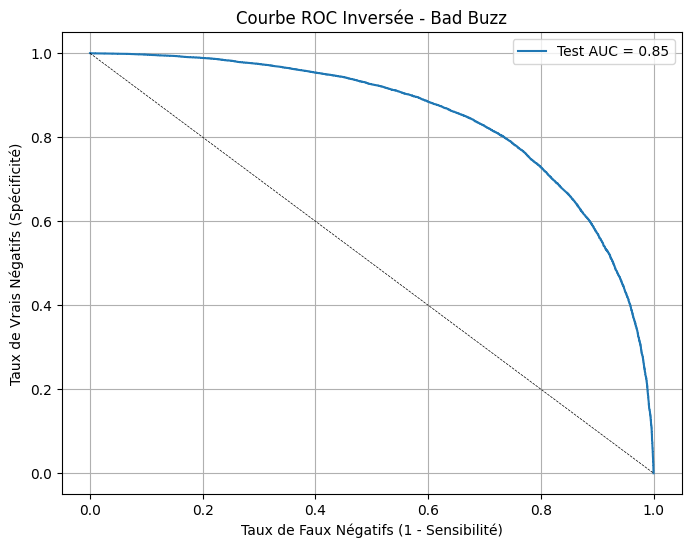

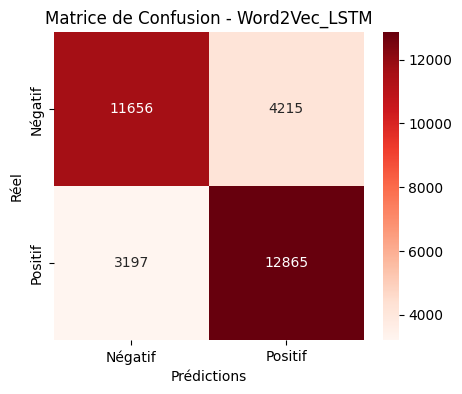


=== üìä Tableau des performances ===
  Performance      Test
0    Accuracy  0.767889
1   Precision  0.753220
2      Recall  0.800959
3    F1 Score  0.776356
1/1 [==============================] - 0s 21ms/step


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmpzl475f80\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmpzl475f80\model\data\model\assets


1/1 [==============================] - 1s 518ms/step


In [55]:
# --- Construction et entra√Ænement du mod√®le LSTM avec MLflow ---

# D√©finition du dossier des mod√®les (remonte d'un niveau vers "models/")
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)

# Chemin pour sauvegarder le meilleur mod√®le Word2Vec LSTM
best_model_path_w2v = models_path / 'best_model_w2v.keras'

# D√©finition des callbacks
checkpoint_cb = ModelCheckpoint(best_model_path_w2v, save_best_only=True, monitor='val_loss', mode='min')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- Construction et entra√Ænement du mod√®le LSTM avec MLflow ---
mlflow.set_experiment("D√©tection des Bad Buzz")

with mlflow.start_run(run_name="Word2Vec_LSTM"):

    model_name = "Word2Vec_LSTM"
    artifact_dir = f"artifacts/{model_name}/"
    os.makedirs(artifact_dir, exist_ok=True)

    mlflow.log_param("model_name", model_name)
    mlflow.log_param("vocab_size", vocab_size_w2v)  
    mlflow.log_param("max_sequence_length", 50)  
    
    # S√©paration en train/test
    X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_padded_w2v, y, test_size=0.2, random_state=42)

    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)

    # D√©finition du mod√®le LSTM
    model_w2v_lstm = Sequential([
        Embedding(input_dim=vocab_size_w2v, output_dim=300, weights=[embedding_matrix_w2v], input_length=50, trainable=False), 
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    
    model_w2v_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # Log des param√®tres du mod√®le LSTM
    mlflow.log_param("embedding_dim", 300)
    mlflow.log_param("lstm_units_1", 128)
    mlflow.log_param("lstm_units_2", 64)
    mlflow.log_param("dropout_rate", 0.5)
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss_function", "binary_crossentropy")
    mlflow.log_param("activation_output", "sigmoid")

    # Entra√Ænement avec callbacks
    history = model_w2v_lstm.fit(
        X_train_w2v, y_train_w2v,
        epochs=10, batch_size=64,
        validation_data=(X_test_w2v, y_test_w2v),
        callbacks=[checkpoint_cb, early_stopping_cb]  # Ajout de la sauvegarde
    )

    # √âvaluation
    test_loss, test_accuracy = model_w2v_lstm.evaluate(X_test_w2v, y_test_w2v)

    # Pr√©dictions pour l'entra√Ænement
    y_train_pred_proba = model_w2v_lstm.predict(X_train_w2v).flatten()
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)

    # Pr√©dictions pour le test
    y_test_pred_proba = model_w2v_lstm.predict(X_test_w2v).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)

    # Calcul des m√©triques g√©n√©rales
    # Accuracy
    test_accuracy = accuracy_score(y_test_w2v, y_test_pred)

    # Pr√©cision = % de pr√©dictions positives correctes
    test_precision = precision_score(y_test_w2v, y_test_pred)

    # Rappel = % de cas positifs bien d√©tect√©s
    test_recall = recall_score(y_test_w2v, y_test_pred)

    # F1-score = √©quilibre entre pr√©cision et rappel
    test_f1 = f1_score(y_test_w2v, y_test_pred)

    # Courbes ROC et AUC
    # Courbe ROC pour les tweets positifs (classe 1)
    fpr_test, tpr_test, _ = roc_curve(y_test_w2v, y_test_pred_proba)

    # Calcul de l'AUC pour la classe positive
    auc_test = auc(fpr_test, tpr_test)

    # Courbes ROC et AUC pour les tweets n√©gatifs (classe 0 - Bad Buzz)
    y_test_pred_proba_neg = 1 - y_test_pred_proba

    fpr_test_neg, tpr_test_neg, _ = roc_curve(y_test_w2v, y_test_pred_proba_neg)

    # Calcul de l'AUC pour la classe n√©gative (bad buzz)
    auc_test_neg = auc(fpr_test_neg, tpr_test_neg)

    # Enregistrement des m√©triques dans MLflow
    mlflow.log_metric("Test Accuracy", test_accuracy)
    mlflow.log_metric("Test Precision", test_precision)
    mlflow.log_metric("Test Recall", test_recall)
    mlflow.log_metric("Test F1 Score", test_f1)
    mlflow.log_metric("Test AUC", auc_test)
    mlflow.log_metric("Test AUC Bad Buzz", auc_test_neg)

    # Courbe ROC invers√©e (bad buzz)
    roc_path_neg = os.path.join(artifact_dir, "roc_curve_bad_buzz.png")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test_neg, 1 - tpr_test_neg, label=f'Test AUC = {1 - auc_test_neg:.2f}', linestyle='-')
    plt.plot([0, 1], [1, 0], 'k--', lw=0.5)
    plt.xlabel('Taux de Faux N√©gatifs (1 - Sensibilit√©)')
    plt.ylabel('Taux de Vrais N√©gatifs (Sp√©cificit√©)')
    plt.title('Courbe ROC Invers√©e - Bad Buzz')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig(roc_path_neg)
    mlflow.log_artifact(roc_path_neg)
    plt.show()

    # Matrice de confusion
    conf_matrix_w2v = confusion_matrix(y_test_w2v, y_test_pred)
    conf_matrix_path_w2v = os.path.join(artifact_dir, "conf_matrix_w2v.png")
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix_w2v, annot=True, fmt='d', cmap='Reds', xticklabels=['N√©gatif', 'Positif'], yticklabels=['N√©gatif', 'Positif'])
    plt.xlabel("Pr√©dictions")
    plt.ylabel("R√©el")
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.savefig(conf_matrix_path_w2v)
    mlflow.log_artifact(conf_matrix_path_w2v)
    plt.show()

    # Tableau des performances
    performance_table_w2v = pd.DataFrame({
        'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Test': [test_accuracy, test_precision, test_recall, test_f1]
    })

    print("\n=== üìä Tableau des performances ===")
    print(performance_table_w2v)

    # Enregistrement du mod√®le TensorFlow avec MLflow
    input_example = np.expand_dims(X_train_w2v[0], axis=0)  
    signature = infer_signature(input_example, model_w2v_lstm.predict(input_example))
    
    mlflow.keras.log_model(model_w2v_lstm, "model_Word2Vec", signature=signature, input_example=input_example)


#### **GloVe + LSTM**

**<u>Commentaire :</u>**

Le nettoyage sera le m√™me que le mod√®le TF-IDF avec StopWords retir√©s et Lemmatisation. Pas besoin de refaire une fonction.

In [56]:
# Fonction clean_text_advanced(text)

**<u>Commentaire :</u>**

Cr√©ation des embeddings GloVe.

In [57]:
import numpy as np

# --- Chargement des embeddings GloVe ---

# D√©finition du chemin vers le fichier GloVe
glove_embeddings_path = "../data/glove.6B.300d.txt"  # Nouveau chemin

embedding_dim = 300  # Taille des vecteurs GloVe

# Charger les embeddings dans un dictionnaire
glove_embeddings = {}
with open(glove_embeddings_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        glove_embeddings[word] = vector

# Afficher le nombre de mots charg√©s
print(f"Nombre de mots charg√©s depuis GloVe : {len(glove_embeddings)}")


Nombre de mots charg√©s depuis GloVe : 400000


**<u>Commentaire :</u>**

Pr√©paration des donn√©es pour le mod√®le LSTM.

In [58]:
# --- Pr√©paration des donn√©es pour le mod√®le LSTM ---

# Nettoyage et tokenisation avanc√©s
data_reduced["text_glove"] = data_reduced["text"].apply(lambda x: word_tokenize(clean_text_advanced(x)))

# Initialisation du tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_reduced["text_glove"])  

# Conversion des tweets en s√©quences num√©riques
X_seq_glove = tokenizer.texts_to_sequences(data_reduced["text_glove"])

# Ajout de padding pour uniformiser la taille des s√©quences
X_padded_glove = pad_sequences(X_seq_glove, maxlen=50, padding="post", truncating="post")  
y = data_reduced["target"]  # Variable cible

print("Dimensions des s√©quences :", X_padded_glove.shape)

# D√©finition du dossier "models"
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)

# Sauvegarde du tokenizer
tokenizer_path = models_path / "tokenizer_glove.json"
with open(tokenizer_path, "w", encoding='utf-8') as f:
    json.dump(tokenizer.to_json(), f)

print(f"Tokenizer GloVe sauvegard√© sous : {tokenizer_path}")


Dimensions des s√©quences : (159663, 50)
Tokenizer GloVe sauvegard√© sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - R√©alisez une analyse de sentiments gr√¢ce au Deep Learning\Git\models\tokenizer_glove.json


**<u>Commentaire :</u>**

V√©rification du dataset.

In [59]:
# --- Check de notre dataset ---

# Afficher 5 lignes du dataset
data_reduced.head()


target                                               text  \
60400         0  had a productive cleaning day yesterday but my...   
397317        0  i just noticed that the world is filled with l...   
465261        0  Hey it is Matt. Waiting for Jen to fall on her...   
591559        0                                        @cawanpink    
1264074       1  Im following a few pointless twitters.. Why?? ...   

                                           clean_text_base  \
60400    had a productive cleaning day yesterday but my...   
397317   i just noticed that the world is filled with l...   
465261   hey it is matt waiting for jen to fall on her ...   
591559                                                       
1264074  im following a few pointless twitters why idk ...   

                                          text_tf_advanced  \
60400    productive cleaning day yesterday shoulder pay...   
397317   noticed world filled lot o amatuears moron srr...   
465261   hey matt waiting jen fall butt damn texting je...   
591559                                                       
1264074  im following pointless twitter idk must change...   

                                                  text_w2v  \
60400    [productive, cleaning, day, yesterday, shoulde...   
397317   [noticed, world, filled, lot, o, amatuears, mo...   
465261   [hey, matt, waiting, jen, fall, butt, damn, te...   
591559                                                  []   
1264074  [im, following, pointless, twitter, idk, must,...   

                                                text_glove  
60400    [productive, cleaning, day, yesterday, shoulde...  
397317   [noticed, world, filled, lot, o, amatuears, mo...  
465261   [hey, matt, waiting, jen, fall, butt, damn, te...  
591559                                                  []  
1264074  [im, following, pointless, twitter, idk, must,...

**<u>Commentaire :</u>**

Cr√©ation de la matrice d‚Äôembeddings GloVe.

In [60]:
# --- Cr√©ation de la matrice d‚Äôembeddings GloVe ---

# Taille du vocabulaire
vocab_size_glove = len(tokenizer.word_index) + 1

# Matrice des embeddings
embedding_matrix_glove = np.zeros((vocab_size_glove, embedding_dim))

# Associer chaque mot de notre vocabulaire aux embeddings GloVe
for word, i in tokenizer.word_index.items():
    if word in glove_embeddings:
        embedding_matrix_glove[i] = glove_embeddings[word]


**<u>Commentaire :</u>**

Construction et entra√Ænement du mod√®le .

Epoch 1/10
1996/1996 [==============================] - 36s 17ms/step - loss: 0.5447 - accuracy: 0.7282 - val_loss: 0.5078 - val_accuracy: 0.7518
Epoch 2/10
1996/1996 [==============================] - 32s 16ms/step - loss: 0.4933 - accuracy: 0.7645 - val_loss: 0.4939 - val_accuracy: 0.7641
Epoch 3/10
1996/1996 [==============================] - 32s 16ms/step - loss: 0.4706 - accuracy: 0.7777 - val_loss: 0.4829 - val_accuracy: 0.7650
Epoch 4/10
1996/1996 [==============================] - 33s 16ms/step - loss: 0.4473 - accuracy: 0.7929 - val_loss: 0.4826 - val_accuracy: 0.7695
Epoch 5/10
1996/1996 [==============================] - 32s 16ms/step - loss: 0.4221 - accuracy: 0.8071 - val_loss: 0.4837 - val_accuracy: 0.7678
Epoch 6/10
1996/1996 [==============================] - 32s 16ms/step - loss: 0.3954 - accuracy: 0.8229 - val_loss: 0.5165 - val_accuracy: 0.7621
Epoch 7/10
998/998 [==============================] - 6s 6ms/step


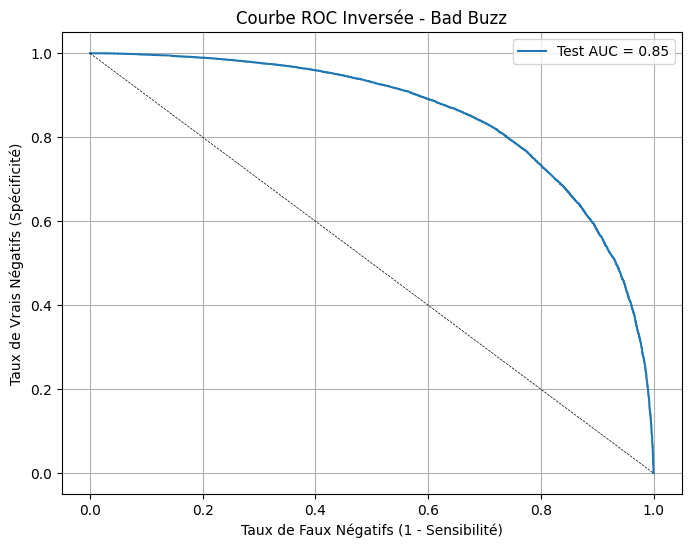

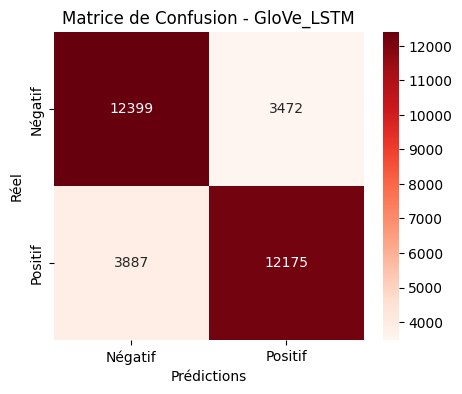


=== üìä Tableau des performances ===
  Performance      Test
0    Accuracy  0.769549
1   Precision  0.778104
2      Recall  0.758000
3    F1 Score  0.767921
1/1 [==============================] - 0s 20ms/step


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmplazxeipb\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmplazxeipb\model\data\model\assets


1/1 [==============================] - 0s 499ms/step
Mod√®le GloVe LSTM sauvegard√© sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - R√©alisez une analyse de sentiments gr√¢ce au Deep Learning\Git\models\best_model_glove.keras


In [61]:
# --- Construction et entra√Ænement du mod√®le ---

# D√©finition du dossier "models"
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)

# Chemin pour sauvegarder le meilleur mod√®le GloVe LSTM
best_model_path_glove = models_path / 'best_model_glove.keras'

# D√©finition des callbacks pour sauvegarde et early stopping
checkpoint_cb = ModelCheckpoint(best_model_path_glove, save_best_only=True, monitor='val_loss', mode='min')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

mlflow.set_experiment("D√©tection des Bad Buzz")

with mlflow.start_run(run_name="GloVe_LSTM"):

    model_name = "GloVe_LSTM"
    artifact_dir = f"artifacts/{model_name}/"
    os.makedirs(artifact_dir, exist_ok=True)

    # Log du nom du mod√®le
    mlflow.log_param("model_name", model_name)

    # Log des param√®tres du tokenizer et de la tokenisation
    mlflow.log_param("vocab_size", vocab_size_glove)
    mlflow.log_param("max_sequence_length", 50)
    
    # S√©paration en train/test
    X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_padded_glove, y, test_size=0.2, random_state=42)

    # Log des param√®tres de la s√©paration train/test
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)
    
    # D√©finition du mod√®le LSTM
    model_glove_lstm = Sequential([
        Embedding(input_dim=vocab_size_glove, output_dim=embedding_dim, weights=[embedding_matrix_glove], input_length=50, trainable=False), 
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    
    model_glove_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # Log des param√®tres du mod√®le LSTM
    mlflow.log_param("embedding_dim", embedding_dim)
    mlflow.log_param("lstm_units_1", 128)
    mlflow.log_param("lstm_units_2", 64)
    mlflow.log_param("dropout_rate", 0.5)
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss_function", "binary_crossentropy")
    mlflow.log_param("activation_output", "sigmoid")

    # Entra√Ænement
    history = model_glove_lstm.fit(
        X_train_glove, y_train_glove,
        epochs=10, batch_size=64,
        validation_data=(X_test_glove, y_test_glove),
        callbacks=[checkpoint_cb, early_stopping_cb]
    )

    # Log des param√®tres d'entra√Ænement
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("early_stopping", "yes")
    mlflow.log_param("early_stopping_patience", 2)

    # √âvaluation
    test_loss, test_accuracy = model_glove_lstm.evaluate(X_test_glove, y_test_glove)

    # Pr√©dictions pour l'entra√Ænement
    y_train_pred_proba = model_glove_lstm.predict(X_train_glove).flatten()
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)

    # Pr√©dictions pour le test
    y_test_pred_proba = model_glove_lstm.predict(X_test_glove).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)

    # Calcul des m√©triques g√©n√©rales
    test_accuracy = accuracy_score(y_test_glove, y_test_pred)

    test_precision = precision_score(y_test_glove, y_test_pred)

    test_recall = recall_score(y_test_glove, y_test_pred)

    test_f1 = f1_score(y_test_glove, y_test_pred)

    # Courbes ROC et AUC
    fpr_test, tpr_test, _ = roc_curve(y_test_glove, y_test_pred_proba)

    auc_test = auc(fpr_test, tpr_test)

    # Courbes ROC et AUC pour les tweets n√©gatifs (bad buzz)
    y_test_pred_proba_neg = 1 - y_test_pred_proba

    fpr_test_neg, tpr_test_neg, _ = roc_curve(y_test_glove, y_test_pred_proba_neg)

    auc_test_neg = auc(fpr_test_neg, tpr_test_neg)

    # Enregistrement des m√©triques dans MLflow
    mlflow.log_metric("Test Accuracy", test_accuracy)
    mlflow.log_metric("Test Precision", test_precision)
    mlflow.log_metric("Test Recall", test_recall)
    mlflow.log_metric("Test F1 Score", test_f1)
    mlflow.log_metric("Test AUC", auc_test)
    mlflow.log_metric("Test AUC Bad Buzz", auc_test_neg)

    # Courbe ROC invers√©e (bad buzz)
    roc_path_neg = os.path.join(artifact_dir, "roc_curve_bad_buzz.png")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test_neg, 1 - tpr_test_neg, label=f'Test AUC = {1 - auc_test_neg:.2f}', linestyle='-')
    plt.plot([0, 1], [1, 0], 'k--', lw=0.5)
    plt.xlabel('Taux de Faux N√©gatifs (1 - Sensibilit√©)')
    plt.ylabel('Taux de Vrais N√©gatifs (Sp√©cificit√©)')
    plt.title('Courbe ROC Invers√©e - Bad Buzz')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig(roc_path_neg)
    mlflow.log_artifact(roc_path_neg)
    plt.show()

    # Matrice de confusion
    conf_matrix_glove = confusion_matrix(y_test_glove, y_test_pred)
    conf_matrix_path_glove = os.path.join(artifact_dir, "conf_matrix_glove.png")
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix_glove, annot=True, fmt='d', cmap='Reds', xticklabels=['N√©gatif', 'Positif'], yticklabels=['N√©gatif', 'Positif'])
    plt.xlabel("Pr√©dictions")
    plt.ylabel("R√©el")
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.savefig(conf_matrix_path_glove)
    mlflow.log_artifact(conf_matrix_path_glove)
    plt.show()

    # Tableau des performances
    performance_table_glove = pd.DataFrame({
        'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Test': [test_accuracy, test_precision, test_recall, test_f1]
    })

    print("\n=== üìä Tableau des performances ===")
    print(performance_table_glove)

    # Sauvegarde du mod√®le avec MLflow
    input_example = np.expand_dims(X_train_glove[0], axis=0)  
    signature = infer_signature(input_example, model_glove_lstm.predict(input_example))
    
    mlflow.keras.log_model(model_glove_lstm, "model_GloVe", signature=signature, input_example=input_example)

print(f"Mod√®le GloVe LSTM sauvegard√© sous : {best_model_path_glove}")

#### **FastText + LSTM**

**<u>Commentaire :</u>**

Le nettoyage sera le m√™me que le mod√®le TF-IDF avec StopWords retir√©s et Lemmatisation. Pas besoin de refaire une fonction.

In [62]:
# Fonction clean_text_advanced(text)

**<u>Commentaire :</u>**

Cr√©ation des embeddings FastText.

In [63]:
# --- Cr√©ation des embeddings FastText ---

# Appliquer le nettoyage avanc√© et tokeniser chaque tweet
data_reduced['text_fasttext'] = data_reduced['text'].apply(lambda x: word_tokenize(clean_text_advanced(x)))

# Entra√Æner le mod√®le FastText
fasttext_model = FastText(
    sentences=data_reduced['text_fasttext'],
    vector_size=300,  # Taille des embeddings
    window=5,
    min_count=5,
    workers=4
)

# Affichage des dimensions du vocabulaire appris
print("Nombre de mots appris par FastText :", len(fasttext_model.wv))


Nombre de mots appris par FastText : 12336


**<u>Commentaire :</u>**

Check du dataset.

In [64]:
# --- Check de notre dataset ---

# Afficher 5 lignes du dataset
data_reduced.head()


target                                               text  \
60400         0  had a productive cleaning day yesterday but my...   
397317        0  i just noticed that the world is filled with l...   
465261        0  Hey it is Matt. Waiting for Jen to fall on her...   
591559        0                                        @cawanpink    
1264074       1  Im following a few pointless twitters.. Why?? ...   

                                           clean_text_base  \
60400    had a productive cleaning day yesterday but my...   
397317   i just noticed that the world is filled with l...   
465261   hey it is matt waiting for jen to fall on her ...   
591559                                                       
1264074  im following a few pointless twitters why idk ...   

                                          text_tf_advanced  \
60400    productive cleaning day yesterday shoulder pay...   
397317   noticed world filled lot o amatuears moron srr...   
465261   hey matt waiting jen fall butt damn texting je...   
591559                                                       
1264074  im following pointless twitter idk must change...   

                                                  text_w2v  \
60400    [productive, cleaning, day, yesterday, shoulde...   
397317   [noticed, world, filled, lot, o, amatuears, mo...   
465261   [hey, matt, waiting, jen, fall, butt, damn, te...   
591559                                                  []   
1264074  [im, following, pointless, twitter, idk, must,...   

                                                text_glove  \
60400    [productive, cleaning, day, yesterday, shoulde...   
397317   [noticed, world, filled, lot, o, amatuears, mo...   
465261   [hey, matt, waiting, jen, fall, butt, damn, te...   
591559                                                  []   
1264074  [im, following, pointless, twitter, idk, must,...   

                                             text_fasttext  
60400    [productive, cleaning, day, yesterday, shoulde...  
397317   [noticed, world, filled, lot, o, amatuears, mo...  
465261   [hey, matt, waiting, jen, fall, butt, damn, te...  
591559                                                  []  
1264074  [im, following, pointless, twitter, idk, must,...

**<u>Commentaire :</u>**

Pr√©paration des donn√©es pour le mod√®le LSTM.

In [65]:
# --- Pr√©paration des donn√©es pour le mod√®le LSTM ---

# Initialisation du tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_reduced["text_fasttext"])  # Bas√© sur les tokens extraits pour FastText

# Conversion des tweets en s√©quences num√©riques
X_seq_fasttext = tokenizer.texts_to_sequences(data_reduced["text_fasttext"])

# Ajout de padding pour uniformiser la taille des s√©quences
X_padded_fasttext = pad_sequences(X_seq_fasttext, maxlen=50, padding="post", truncating="post")  # 50 mots max par tweet
y = data_reduced["target"]  # Variable cible

print("Dimensions des s√©quences :", X_padded_fasttext.shape)

# D√©finition du dossier "models"
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)

# Sauvegarde du tokenizer
tokenizer_path = models_path / "tokenizer_fasttext.json"
with open(tokenizer_path, "w", encoding='utf-8') as f:
    json.dump(tokenizer.to_json(), f)

print(f"Tokenizer FastText sauvegard√© sous : {tokenizer_path}")


Dimensions des s√©quences : (159663, 50)
Tokenizer FastText sauvegard√© sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - R√©alisez une analyse de sentiments gr√¢ce au Deep Learning\Git\models\tokenizer_fasttext.json


**<u>Commentaire :</u>**

Cr√©ation de la matrice d‚Äôembeddings.

In [66]:
# --- Cr√©ation de la matrice d‚Äôembeddings ---

# Taille du vocabulaire
vocab_size_fasttext = len(tokenizer.word_index) + 1

# Matrice des embeddings
embedding_matrix_fasttext = np.zeros((vocab_size_fasttext, 300))

# Associer chaque mot de notre vocabulaire aux embeddings FastText
for word, i in tokenizer.word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix_fasttext[i] = fasttext_model.wv[word]


**<u>Commentaire :</u>**

Construction et entra√Ænement du mod√®le.

Epoch 1/10
1996/1996 [==============================] - 35s 17ms/step - loss: 0.5353 - accuracy: 0.7321 - val_loss: 0.5168 - val_accuracy: 0.7414
Epoch 2/10
1996/1996 [==============================] - 33s 16ms/step - loss: 0.5077 - accuracy: 0.7511 - val_loss: 0.4943 - val_accuracy: 0.7600
Epoch 3/10
1996/1996 [==============================] - 35s 17ms/step - loss: 0.4952 - accuracy: 0.7584 - val_loss: 0.4898 - val_accuracy: 0.7610
Epoch 4/10
1996/1996 [==============================] - 33s 17ms/step - loss: 0.4833 - accuracy: 0.7654 - val_loss: 0.4885 - val_accuracy: 0.7645
Epoch 5/10
1996/1996 [==============================] - 33s 16ms/step - loss: 0.4734 - accuracy: 0.7710 - val_loss: 0.4856 - val_accuracy: 0.7637
Epoch 6/10
1996/1996 [==============================] - 33s 16ms/step - loss: 0.4630 - accuracy: 0.7774 - val_loss: 0.4905 - val_accuracy: 0.7594
Epoch 7/10
1996/1996 [==============================] - 35s 17ms/step - loss: 0.4529 - accuracy: 0.7841 - val_loss: 0.4865 -

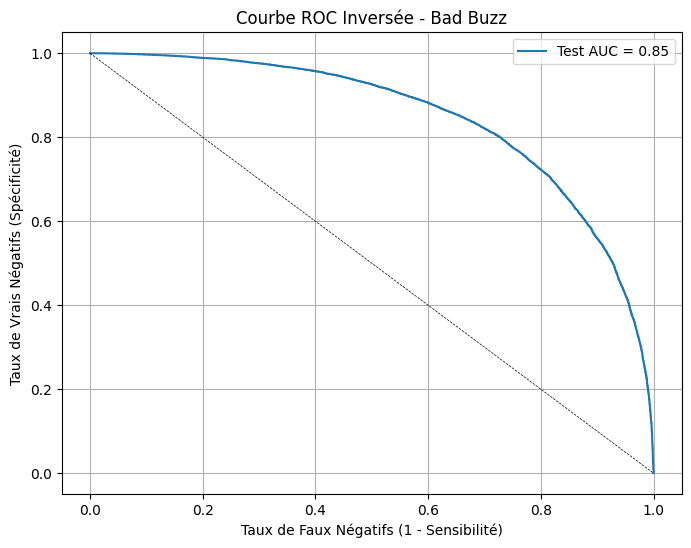

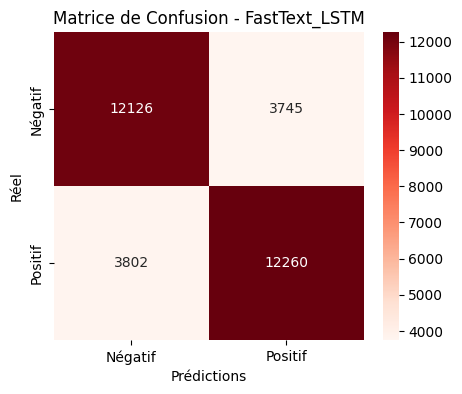


=== üìä Tableau des performances ===
  Performance      Test
0    Accuracy  0.763661
1   Precision  0.766011
2      Recall  0.763292
3    F1 Score  0.764649
1/1 [==============================] - 0s 19ms/step


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmpwbh941sa\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmpwbh941sa\model\data\model\assets


1/1 [==============================] - 0s 493ms/step
Mod√®le FastText LSTM sauvegard√© sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - R√©alisez une analyse de sentiments gr√¢ce au Deep Learning\Git\models\best_model_fasttext.keras


In [67]:
# --- Construction et entra√Ænement du mod√®le FastText ---

# D√©finition du dossier "models"
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)

# Chemin pour sauvegarder le meilleur mod√®le FastText LSTM
best_model_path_fasttext = models_path / 'best_model_fasttext.keras'

# D√©finition des callbacks pour sauvegarde et early stopping
checkpoint_cb = ModelCheckpoint(best_model_path_fasttext, save_best_only=True, monitor='val_loss', mode='min')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

mlflow.set_experiment("D√©tection des Bad Buzz")

with mlflow.start_run(run_name="FastText_LSTM"):

    model_name = "FastText_LSTM"
    artifact_dir = f"artifacts/{model_name}/"
    os.makedirs(artifact_dir, exist_ok=True)

    # Log du nom du mod√®le
    mlflow.log_param("model_name", model_name)

    # Log des param√®tres du mod√®le FastText
    mlflow.log_param("fasttext_vector_size", 300)
    mlflow.log_param("fasttext_window", 5)
    mlflow.log_param("fasttext_min_count", 5)
    mlflow.log_param("fasttext_workers", 4)
        
    # Log des param√®tres du tokenizer et de la tokenisation
    mlflow.log_param("vocab_size", vocab_size_fasttext)
    mlflow.log_param("max_sequence_length", 50)
        
    # S√©paration en train/test
    X_train_fasttext, X_test_fasttext, y_train_fasttext, y_test_fasttext = train_test_split(X_padded_fasttext, y, test_size=0.2, random_state=42)
    
    # Log des param√®tres de la s√©paration train/test
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)
    
    # D√©finition du mod√®le LSTM
    model_fasttext_lstm = Sequential([
        Embedding(input_dim=vocab_size_fasttext, output_dim=embedding_dim, weights=[embedding_matrix_fasttext], input_length=50, trainable=False), 
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    
    model_fasttext_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # Log des param√®tres du mod√®le LSTM
    mlflow.log_param("embedding_dim", 300)
    mlflow.log_param("lstm_units_1", 128)
    mlflow.log_param("lstm_units_2", 64)
    mlflow.log_param("dropout_rate", 0.5)
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss_function", "binary_crossentropy")
    mlflow.log_param("activation_output", "sigmoid")
    
    # Entra√Ænement
    history = model_fasttext_lstm.fit(
        X_train_fasttext, y_train_fasttext,
        epochs=10, batch_size=64,
        validation_data=(X_test_fasttext, y_test_fasttext),
        callbacks=[checkpoint_cb, early_stopping_cb]
    )

    # Log des param√®tres d'entra√Ænement
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("early_stopping", "yes")
    mlflow.log_param("early_stopping_patience", 2)
    
    # √âvaluation
    test_loss, test_accuracy = model_fasttext_lstm.evaluate(X_test_fasttext, y_test_fasttext)

    # Pr√©dictions pour l'entra√Ænement
    y_train_pred_proba = model_fasttext_lstm.predict(X_train_fasttext).flatten()
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)

    # Pr√©dictions pour le test
    y_test_pred_proba = model_fasttext_lstm.predict(X_test_fasttext).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)

    # Calcul des m√©triques g√©n√©rales
    test_accuracy = accuracy_score(y_test_fasttext, y_test_pred)

    test_precision = precision_score(y_test_fasttext, y_test_pred)

    test_recall = recall_score(y_test_fasttext, y_test_pred)

    test_f1 = f1_score(y_test_fasttext, y_test_pred)

    # Courbes ROC et AUC
    fpr_test, tpr_test, _ = roc_curve(y_test_fasttext, y_test_pred_proba)

    auc_test = auc(fpr_test, tpr_test)

    # Courbes ROC et AUC pour les tweets n√©gatifs (bad buzz)
    y_test_pred_proba_neg = 1 - y_test_pred_proba

    fpr_test_neg, tpr_test_neg, _ = roc_curve(y_test_fasttext, y_test_pred_proba_neg)

    auc_test_neg = auc(fpr_test_neg, tpr_test_neg)


    # Enregistrement des m√©triques dans MLflow
    mlflow.log_metric("Test Accuracy", test_accuracy)
    mlflow.log_metric("Test Precision", test_precision)
    mlflow.log_metric("Test Recall", test_recall)
    mlflow.log_metric("Test F1 Score", test_f1)
    mlflow.log_metric("Test AUC", auc_test)
    mlflow.log_metric("Test AUC Bad Buzz", auc_test_neg)

    # Courbe ROC invers√©e (bad buzz)
    roc_path_neg = os.path.join(artifact_dir, "roc_curve_bad_buzz.png")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test_neg, 1 - tpr_test_neg, label=f'Test AUC = {1 - auc_test_neg:.2f}', linestyle='-')
    plt.plot([0, 1], [1, 0], 'k--', lw=0.5)
    plt.xlabel('Taux de Faux N√©gatifs (1 - Sensibilit√©)')
    plt.ylabel('Taux de Vrais N√©gatifs (Sp√©cificit√©)')
    plt.title('Courbe ROC Invers√©e - Bad Buzz')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig(roc_path_neg)
    mlflow.log_artifact(roc_path_neg)
    plt.show()

    # Matrice de confusion
    conf_matrix_fasttext = confusion_matrix(y_test_fasttext, y_test_pred)
    conf_matrix_path_fasttext = os.path.join(artifact_dir, "conf_matrix_fasttext.png")
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix_fasttext, annot=True, fmt='d', cmap='Reds', xticklabels=['N√©gatif', 'Positif'], yticklabels=['N√©gatif', 'Positif'])
    plt.xlabel("Pr√©dictions")
    plt.ylabel("R√©el")
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.savefig(conf_matrix_path_fasttext)
    mlflow.log_artifact(conf_matrix_path_fasttext)
    plt.show()

    # Tableau des performances
    performance_table_fasttext = pd.DataFrame({
        'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Test': [test_accuracy, test_precision, test_recall, test_f1]
    })

    print("\n=== üìä Tableau des performances ===")
    print(performance_table_fasttext)

    # Sauvegarde du mod√®le avec MLflow
    input_example = np.expand_dims(X_train_fasttext[0], axis=0)  
    signature = infer_signature(input_example, model_fasttext_lstm.predict(input_example))
    
    mlflow.keras.log_model(model_fasttext_lstm, "model_FastText", signature=signature, input_example=input_example)

print(f"Mod√®le FastText LSTM sauvegard√© sous : {best_model_path_fasttext}")


#### **BERT**

**<u>Commentaire :</u>**

Chargement du mod√®le BERT et Tokenizer.

In [68]:
# --- Chargement du mod√®le BERT Distill√© et Tokenizer ---

# Charger le tokenizer DistilBERT pr√©-entra√Æn√©
bert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Charger le mod√®le DistilBERT pr√©-entra√Æn√©
bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

print("Mod√®le DistilBERT charg√© avec succ√®s.")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Mod√®le DistilBERT charg√© avec succ√®s.


**<u>Commentaire :</u>**

Pr√©traitement des textes pour BERT.

In [69]:
# --- Pr√©traitement des donn√©es pour BERT ---

# Encode les textes avec le tokenizer BERT en entr√©e pour le mod√®le
def encode_texts_bert(texts, max_length=64):
    return bert_tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

# Encodage des tweets
encoded_texts = encode_texts_bert(data_reduced['text'])

# Extraction des entr√©es n√©cessaires √† BERT
X_bert = encoded_texts['input_ids']
y = data_reduced['target']

# Afficher les dimensions
print("Encodage termin√©. Dimensions des s√©quences :", X_bert.shape)

# D√©finition du dossier "models"
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)

# Sauvegarde du tokenizer BERT
bert_tokenizer_path = models_path / "bert_tokenizer"
bert_tokenizer.save_pretrained(bert_tokenizer_path)

print(f"Tokenizer BERT sauvegard√© sous : {bert_tokenizer_path}")


Encodage termin√©. Dimensions des s√©quences : (159663, 64)
Tokenizer BERT sauvegard√© sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - R√©alisez une analyse de sentiments gr√¢ce au Deep Learning\Git\models\bert_tokenizer


**<u>Commentaire :</u>**

S√©paration des donn√©es train / test.

In [70]:
# --- S√©paration des donn√©es en train/test ---

# Conversion des labels en tenseurs float32
y = tf.convert_to_tensor(y, dtype=tf.float32)

# --- S√©paration train/test ---
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    X_bert.numpy(), y.numpy(), test_size=0.2, random_state=42
)

print("S√©paration train/test effectu√©e.")


S√©paration train/test effectu√©e.


**<u>Commentaire :</u>**

Construction et entra√Ænement du mod√®le BERT.

Mod√®le BERT et tenseurs plac√©s sur : /gpu:0
Epoch 1/5
7984/7984 [==============================] - 355s 44ms/step - loss: 0.4174 - accuracy: 0.8188 - val_loss: 0.3801 - val_accuracy: 0.8399
Epoch 2/5
7984/7984 [==============================] - 340s 43ms/step - loss: 0.3192 - accuracy: 0.8682 - val_loss: 0.3789 - val_accuracy: 0.8414
Epoch 3/5
7984/7984 [==============================] - 337s 42ms/step - loss: 0.2234 - accuracy: 0.9123 - val_loss: 0.4291 - val_accuracy: 0.8384
Epoch 4/5
7984/7984 [==============================] - 336s 42ms/step - loss: 0.1408 - accuracy: 0.9471 - val_loss: 0.4841 - val_accuracy: 0.8371
Epoch 5/5
998/998 [==============================] - 19s 18ms/step


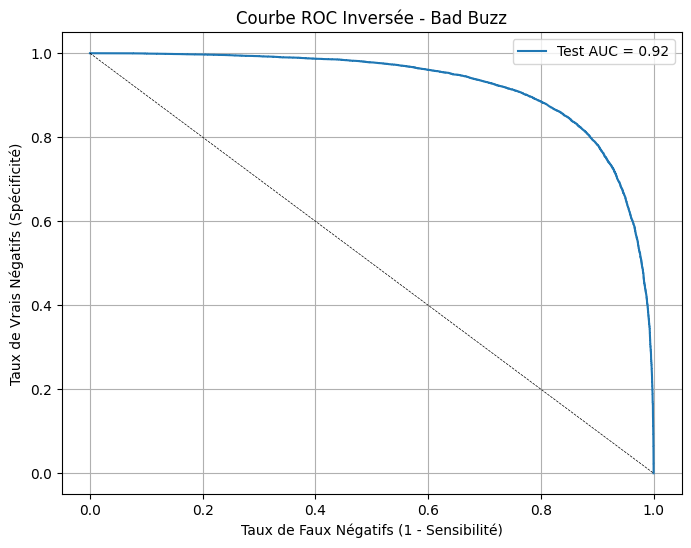

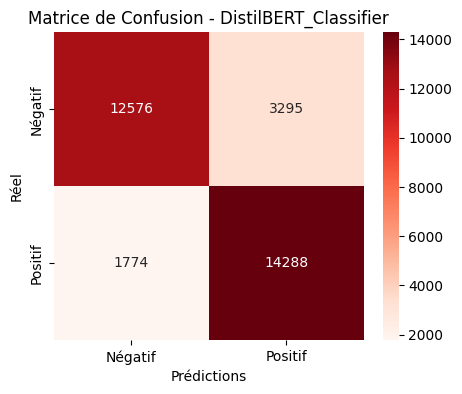


=== üìä Tableau des performances ===
  Performance      Test
0    Accuracy  0.841261
1   Precision  0.812603
2      Recall  0.889553
3    F1 Score  0.849339
1/1 [==============================] - 0s 31ms/step


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmpt9o2vf7q\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmpt9o2vf7q\model\data\model\assets
2025/02/17 11:00:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\MOUSSE~1\AppData\Local\Temp\tmpt9o2vf7q\model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback. 


2025/02/17 11:00:22 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    [
      101,
      2987,
      1005,
      1056,
      2514,
      2205,
      2092,
      102,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0
    ]
  ]
}. Alternatively, you can avoid passing input example and pass model signature instead when logging the model. To ensure the input example is valid prior to serving, please try calling `mlflow.models.validate_serving_input` on the model uri and serving input example. A serving inp

Sauvegardes effectu√©es avec succ√®s :
Mod√®le de classification DistilBERT sauvegard√© sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - R√©alisez une analyse de sentiments gr√¢ce au Deep Learning\Git\models\best_model_bert.keras
Mod√®le pr√©-entra√Æn√© DistilBERT sauvegard√© sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - R√©alisez une analyse de sentiments gr√¢ce au Deep Learning\Git\models\distilbert_model


In [71]:
# --- Construction et entra√Ænement du mod√®le BERT ---

# D√©finition du dossier "models"
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)

# Chemin pour sauvegarder le meilleur mod√®le BERT
best_model_path_bert = models_path / 'best_model_bert.keras'

# D√©finition des callbacks pour sauvegarde et early stopping
checkpoint_cb = ModelCheckpoint(best_model_path_bert, save_best_only=True, monitor='val_loss', mode='min')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# D√©bloquer l'entra√Ænement des couches BERT
#for layer in bert_model.layers:
#    layer.trainable = True

# D√©sactiver le pooler qui est inutile
#for layer in bert_model.layers:
#    if "pooler" in layer.name:
#        layer.trainable = False
        
mlflow.set_experiment("D√©tection des Bad Buzz")

with mlflow.start_run(run_name="DistilBERT_Classifier"):

    model_name = "DistilBERT_Classifier"
    artifact_dir = f"artifacts/{model_name}/"
    os.makedirs(artifact_dir, exist_ok=True)

    # Log du mod√®le
    mlflow.log_param("model_name", model_name)
    mlflow.log_param("max_sequence_length", 64)
    
    # Architecture BERT corrig√©e
    input_layer = tf.keras.layers.Input(shape=(64,), dtype=tf.int32, name="input_ids")
    
    # R√©cup√©ration des embeddings BERT sans pooler
    bert_output = bert_model(input_layer)[0]  
    cls_token = tf.keras.layers.Dense(bert_output.shape[-1], activation=None)(bert_output[:, 0, :])
    
    dropout_layer = tf.keras.layers.Dropout(0.4)(cls_token)
    output_layer = tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout_layer)

    model_bert = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    # Optimiseur AdamW + Scheduler
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

    model_bert.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    # V√©rification GPU
    device = "/gpu:0" if tf.config.list_physical_devices('GPU') else "/cpu:0"
    with tf.device(device):
        X_train_bert = tf.convert_to_tensor(X_train_bert, dtype=tf.int32)
        X_test_bert = tf.convert_to_tensor(X_test_bert, dtype=tf.int32)
        y_train_bert = tf.convert_to_tensor(y_train_bert, dtype=tf.float32)
        y_test_bert = tf.convert_to_tensor(y_test_bert, dtype=tf.float32)

    print(f"Mod√®le BERT et tenseurs plac√©s sur : {device}")

    # Callbacks pour optimiser l'entra√Ænement
    scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1) # patience=1 comme √ßa la LR diminue d√®s que val_loss stagne
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    # Entra√Ænement
    history = model_bert.fit(
        X_train_bert, y_train_bert,
        epochs=5, batch_size=16,
        validation_data=(X_test_bert, y_test_bert),
        callbacks=[checkpoint_cb, early_stopping_cb]
    )

    # √âvaluation
    test_loss, test_accuracy = model_bert.evaluate(X_test_bert, y_test_bert)

    # Pr√©dictions pour le test
    y_test_pred_proba = model_bert.predict(X_test_bert).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)

    # Calcul des m√©triques g√©n√©rales
    test_precision = precision_score(y_test_bert, y_test_pred)
    test_recall = recall_score(y_test_bert, y_test_pred)
    test_f1 = f1_score(y_test_bert, y_test_pred)

    # Courbes ROC et AUC
    fpr_test, tpr_test, _ = roc_curve(y_test_bert, y_test_pred_proba)
    auc_test = auc(fpr_test, tpr_test)

    # Courbes ROC et AUC pour les tweets n√©gatifs (bad buzz)
    y_test_pred_proba_neg = 1 - y_test_pred_proba
    fpr_test_neg, tpr_test_neg, _ = roc_curve(y_test_bert, y_test_pred_proba_neg)
    auc_test_neg = auc(fpr_test_neg, tpr_test_neg)

    # Enregistrement des m√©triques dans MLflow
    mlflow.log_metric("Test Accuracy", test_accuracy)
    mlflow.log_metric("Test Precision", test_precision)
    mlflow.log_metric("Test Recall", test_recall)
    mlflow.log_metric("Test F1 Score", test_f1)
    mlflow.log_metric("Test AUC", auc_test)
    mlflow.log_metric("Test AUC Bad Buzz", auc_test_neg)

    # Courbe ROC invers√©e (bad buzz)
    roc_path_neg = os.path.join(artifact_dir, "roc_curve_bad_buzz.png")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test_neg, 1 - tpr_test_neg, label=f'Test AUC = {1 - auc_test_neg:.2f}', linestyle='-')
    plt.plot([0, 1], [1, 0], 'k--', lw=0.5)
    plt.xlabel('Taux de Faux N√©gatifs (1 - Sensibilit√©)')
    plt.ylabel('Taux de Vrais N√©gatifs (Sp√©cificit√©)')
    plt.title('Courbe ROC Invers√©e - Bad Buzz')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig(roc_path_neg)
    mlflow.log_artifact(roc_path_neg)
    plt.show()

    # Matrice de confusion
    conf_matrix_bert = confusion_matrix(y_test_bert, y_test_pred)
    conf_matrix_path_bert = os.path.join(artifact_dir, "conf_matrix_bert.png")
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix_bert, annot=True, fmt='d', cmap='Reds', xticklabels=['N√©gatif', 'Positif'], yticklabels=['N√©gatif', 'Positif'])
    plt.xlabel("Pr√©dictions")
    plt.ylabel("R√©el")
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.savefig(conf_matrix_path_bert)
    mlflow.log_artifact(conf_matrix_path_bert)
    plt.show()

    # Tableau des performances
    performance_table_bert = pd.DataFrame({
        'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Test': [test_accuracy, test_precision, test_recall, test_f1]
    })

    print("\n=== üìä Tableau des performances ===")
    print(performance_table_bert)

    # Sauvegarde du mod√®le avec MLflow
    input_example = np.expand_dims(X_test_bert[0], axis=0)  
    signature = infer_signature(input_example, model_bert.predict(input_example))
    
    mlflow.keras.log_model(model_bert, "model_BERT", signature=signature, input_example=input_example)

    # Sauvegarde du mod√®le DistilBERT
    bert_model_path = models_path / "distilbert_model"
    bert_model.save_pretrained(bert_model_path)
    
# Affichage 
print(f"Sauvegardes effectu√©es avec succ√®s :\n"
      f"Mod√®le de classification DistilBERT sauvegard√© sous : {best_model_path_bert}\n"
      f"Mod√®le pr√©-entra√Æn√© DistilBERT sauvegard√© sous : {bert_model_path}")